In [1]:
import numpy as np
import pandas as pd
import json
import random

n = 50
customer = [i for i in range(1, n + 1)]
node = [0] + customer
arcos = [(i,j) for i in node for j in node if i != j]
f = open('pelanggan.json')
data = json.load(f)
# get customer demand and location data
df = pd.DataFrame(data)
# print(df)
# get distance data
distance = np.loadtxt('distance.txt')
vehicle_capacity = 250
demand = df.demand

In [2]:
default = 0.2
Q = np.zeros((len(node),len(node)))
for i in range(len(node)):
    for j in range(len(node)):
        if(i!=j):
            Q[i][j] = default
DA = np.array([0])
np.savetxt('Q.txt', Q)
np.savetxt('DA.txt',DA)

In [3]:
miu = 0.05
diskon = 0.9
epsilon = 0.05

def bestq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    max_value = np.max(curr_qtable)
    result = np.where(curr_qtable == max_value)[0]
    if(len(result) == 1):
        return node[result[0]]
    else:
        rnd = random.randint(0,len(result)-1)
        return node[result[rnd]]

def randomq(node):
    result = random.randint(0,len(node)-1)
    return node[result]

def maxq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    max_value = np.max(curr_qtable)
    return max_value

def minq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    min_value = np.min(curr_qtable)
    return min_value

def countDistance(route):
    total = 0
    for n in range(len(route)):
        total+=distance[route[n][0]][route[n][1]]
    return total

def updateQ(Q, croute, nodes, total):
    DA = np.loadtxt('DA.txt')
    # r = 1
    #Fungsi untuk Rewrard
    if DA == 0:
        DA = total
        DAnew = total
    else: 
        DAnew = (DA + total)/2
    if(DA>total):
        rn = 1
    else:
        rn = 0
    #End Fungsi untuk Reward
    Qnew = np.copy(Q)
    for k in range(len(croute)):
        route = croute[k]
        node = nodes[k]
        for n in range(len(route) - 1):
            i = route[n][0]
            j = route[n][1]
            if(n == len(route) - 1 ):
                r = rn
            else:
                r = 0
            Qnew[i][j] = Q[i][j] + ( miu * ( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j] ) )
    np.savetxt('Q.txt', Qnew)  
    np.savetxt('DA.txt', np.array([DAnew]))

def updateQ2(Q, croute, nodes, total):
    DA = np.loadtxt('DA.txt')
    # r = 1
    #Fungsi untuk Rewrard
    if DA == 0:
        DA = total
        
    if(DA>total):
        rn = 1
        DA = total
    else:
        rn = 0
    #End Fungsi untuk Reward
    Qnew = np.copy(Q)
    for k in range(len(croute)):
        route = croute[k]
        node = nodes[k]
        for n in range(len(route) - 1):
            i = route[n][0]
            j = route[n][1]
            if(n == len(route) - 1 ):
                r = rn
            else:
                r = 0
            Qnew[i][j] = Q[i][j] + ( miu * ( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j] ) )
    np.savetxt('Q.txt', Qnew)  
    np.savetxt('DA.txt', np.array([DA]))

def updateQ3(Q, croute, nodes, total):
    DA = np.loadtxt('DA.txt')
    # r = 1
    #Fungsi untuk Rewrard
    if DA == 0:
        DA = total
        
    if(DA>=total):
        r = 1
        DA = total
    else:
        r = 0
    #End Fungsi untuk Reward
    print(r)
    Qnew = np.copy(Q)
    for k in range(len(croute)):
        route = croute[k]
#         print(route)
        node = nodes[k]
        for n in range(len(route) - 1):
            i = route[n][0]
            j = route[n][1]
            Qnew[i][j] = Q[i][j] + ( miu * ( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j] ) )
#             print(Q[i][j])
#             print( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j])
#             print(Qnew[i][j])
    np.savetxt('Q.txt', Qnew)  
    np.savetxt('DA.txt', np.array([DA]))


In [4]:
MaxEpisode = 1200
episode = 0
cek1 = []
cek2 = []
best_route=[]
best_distance=0
###Menghitung Waktu
import time
start_timer = time.time()

while(episode < MaxEpisode):
    Q = np.loadtxt('Q.txt')
    nodes = np.array(node)
    nodes = np.delete(nodes, [0])
    capacity = vehicle_capacity
    route = 1
    routes = []
    rnode = []
    croute = []
    crnode = []
    i = 0
    total_dis = 0
    while(len(nodes)>0):
        greed = random.random()
        if(len(nodes) == 1):
            j = nodes[0]
            if (capacity - demand[j]) < 0 :
                routes.append([i,0])
                rnode.append(  np.insert(np.copy(nodes), 0, 0) )
                croute.append(routes)
                crnode.append(rnode)
                #
                total_dis+=countDistance(routes)
                #
                i = 0
                routes = []
                rnode = []
                route += 1                
            routes.append([i,j])
            routes.append([j,0]) 
            rnode.append(  np.insert(np.copy(nodes), 0, 0) )
            croute.append(routes)
            crnode.append(rnode)
            #
            total_dis+=countDistance(routes)
            #
            i = 0
            routes = []
            rnode = []
            route += 1  
            break
        if greed < epsilon :
            #Exploration Move
            j = randomq(nodes)
        else:
            #Exploitation Move
            j = bestq(Q, nodes, i)
        if (capacity - demand[j]) > 0 :
            routes.append([i,j])
            rnode.append( np.insert(np.copy(nodes), 0, 0) )
            getndex = np.where(nodes == j)[0]
            nodes = np.delete(nodes, [getndex])
            capacity -= demand[j]
            i = j
        else:
            routes.append([i,0])
            rnode.append( np.insert(np.copy(nodes), 0, 0) )
            croute.append(routes)
            crnode.append(rnode)
            #
            total_dis+=countDistance(routes)
            #
            i = 0
            routes = []
            rnode = []
            route += 1
            capacity = vehicle_capacity

    print("Episode : "+str(episode))
    updateQ3(Q, croute, crnode,total_dis)
    cek1.append(episode)
    cek2.append(total_dis)
    for n in range(route - 1):
        print("Rute "+str(n)+" : "+str(croute[n]))
    episode += 1
    print("Total Distace : "+str(total_dis))
    print("-------------------------")    
    if ( best_distance == 0) or (best_distance>total_dis) :
        best_distance = total_dis
        best_route = croute

###Menghitung Waktu
done_timer = time.time()
elapsed = done_timer - start_timer
print("") 
print("") 
print("----------BEST ROUTE---------------") 
for n in range(len(best_route)):
    print("Rute "+str(n)+" : "+str(best_route[n]))
print("Total Distace : "+str(best_distance))


Episode : 0
1
Rute 0 : [[0, 36], [36, 30], [30, 18], [18, 20], [20, 2], [2, 34], [34, 38], [38, 0]]
Rute 1 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 0]]
Rute 2 : [[0, 37], [37, 11], [11, 27], [27, 16], [16, 0]]
Rute 3 : [[0, 29], [29, 6], [6, 33], [33, 45], [45, 35], [35, 49], [49, 0]]
Rute 4 : [[0, 32], [32, 1], [1, 5], [5, 7], [7, 40], [40, 50], [50, 9], [9, 0]]
Rute 5 : [[0, 22], [22, 31], [31, 15], [15, 14], [14, 17], [17, 4], [4, 10], [10, 0]]
Rute 6 : [[0, 42], [42, 28], [28, 44], [44, 43], [43, 13], [13, 0]]
Rute 7 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 39], [39, 0]]
Rute 8 : [[0, 19], [19, 47], [47, 0]]
Total Distace : 321908.0
-------------------------
Episode : 1
0
Rute 0 : [[0, 36], [36, 30], [30, 18], [18, 20], [20, 2], [2, 34], [34, 38], [38, 0]]
Rute 1 : [[0, 32], [32, 1], [1, 5], [5, 7], [7, 40], [40, 50], [50, 9], [9, 0]]
Rute 2 : [[0, 19], [19, 47], [47, 28], [28, 12], [12, 41], [41, 0]]
Rute 3 : [[0, 42], [42, 29], [29, 6], [6, 3

0
Rute 0 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 39], [39, 0]]
Rute 1 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 2 : [[0, 29], [29, 6], [6, 33], [33, 10], [10, 45], [45, 0]]
Rute 3 : [[0, 37], [37, 11], [11, 14], [14, 17], [17, 16], [16, 0]]
Rute 4 : [[0, 36], [36, 47], [47, 28], [28, 44], [44, 43], [43, 13], [13, 31], [31, 20], [20, 0]]
Rute 5 : [[0, 32], [32, 50], [50, 9], [9, 5], [5, 7], [7, 40], [40, 18], [18, 0]]
Rute 6 : [[0, 19], [19, 35], [35, 49], [49, 15], [15, 1], [1, 0]]
Rute 7 : [[0, 42], [42, 30], [30, 34], [34, 38], [38, 4], [4, 0]]
Rute 8 : [[0, 22], [22, 2], [2, 0]]
Total Distace : 295343.0
-------------------------
Episode : 15
0
Rute 0 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 39], [39, 0]]
Rute 1 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 2 : [[0, 10], [10, 45], [45, 35], [35, 49], [49, 7], [7, 17], [17, 0]]
Rute 3 : [[0, 29], [29, 6], [6, 33], [33, 11], [11

Episode : 27
0
Rute 0 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 39], [39, 0]]
Rute 1 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 4], [4, 10], [10, 45], [45, 0]]
Rute 2 : [[0, 29], [29, 6], [6, 33], [33, 11], [11, 27], [27, 0]]
Rute 3 : [[0, 32], [32, 50], [50, 9], [9, 5], [5, 7], [7, 17], [17, 0]]
Rute 4 : [[0, 36], [36, 47], [47, 28], [28, 44], [44, 43], [43, 13], [13, 0]]
Rute 5 : [[0, 37], [37, 18], [18, 20], [20, 2], [2, 34], [34, 38], [38, 0]]
Rute 6 : [[0, 22], [22, 31], [31, 42], [42, 30], [30, 14], [14, 15], [15, 0]]
Rute 7 : [[0, 19], [19, 35], [35, 49], [49, 40], [40, 16], [16, 1], [1, 0]]
Rute 8 : [[0, 25], [25, 26], [26, 0]]
Total Distace : 288018.0
-------------------------
Episode : 28
0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 39], [39, 0]]
Rute 2 : [[0, 29], [29, 15], [15, 18], [18, 20], [20, 2], [2, 34], [34, 0]]
Rute 3 : [[0, 32], [32, 50], [50, 9],

0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 29], [29, 6], [6, 33], [33, 45], [45, 35], [35, 49], [49, 0]]
Rute 2 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 39], [39, 0]]
Rute 3 : [[0, 28], [28, 44], [44, 43], [43, 13], [13, 40], [40, 50], [50, 0]]
Rute 4 : [[0, 36], [36, 47], [47, 34], [34, 38], [38, 4], [4, 0]]
Rute 5 : [[0, 32], [32, 1], [1, 5], [5, 7], [7, 17], [17, 16], [16, 0]]
Rute 6 : [[0, 22], [22, 31], [31, 9], [9, 18], [18, 20], [20, 2], [2, 15], [15, 14], [14, 0]]
Rute 7 : [[0, 37], [37, 11], [11, 42], [42, 30], [30, 0]]
Rute 8 : [[0, 19], [19, 10], [10, 0]]
Total Distace : 293216.0
-------------------------
Episode : 40
0
Rute 0 : [[0, 3], [3, 23], [23, 18], [18, 20], [20, 2], [2, 16], [16, 30], [30, 0]]
Rute 1 : [[0, 29], [29, 6], [6, 33], [33, 45], [45, 35], [35, 49], [49, 0]]
Rute 2 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 7], [7, 17], [17, 0]]
Rute 3 : [[0, 36], [36, 47], [47, 28], [28, 5], [5, 

Episode : 51
0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 29], [29, 6], [6, 33], [33, 45], [45, 35], [35, 49], [49, 0]]
Rute 2 : [[0, 46], [46, 48], [48, 21], [21, 16], [16, 30], [30, 0]]
Rute 3 : [[0, 36], [36, 47], [47, 28], [28, 44], [44, 43], [43, 13], [13, 40], [40, 0]]
Rute 4 : [[0, 22], [22, 31], [31, 20], [20, 2], [2, 34], [34, 38], [38, 0]]
Rute 5 : [[0, 32], [32, 50], [50, 9], [9, 5], [5, 7], [7, 17], [17, 4], [4, 0]]
Rute 6 : [[0, 37], [37, 11], [11, 39], [39, 24], [24, 8], [8, 0]]
Rute 7 : [[0, 14], [14, 15], [15, 18], [18, 10], [10, 1], [1, 0]]
Rute 8 : [[0, 42], [42, 19], [19, 0]]
Total Distace : 321918.0
-------------------------
Episode : 52
0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 29], [29, 6], [6, 33], [33, 45], [45, 35], [35, 49], [49, 0]]
Rute 2 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 39], [39, 0]]
Rute 3 : [[0, 36], [36, 47], [47, 28]

0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 29], [29, 6], [6, 33], [33, 45], [45, 35], [35, 49], [49, 0]]
Rute 2 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 39], [39, 0]]
Rute 3 : [[0, 36], [36, 47], [47, 28], [28, 16], [16, 30], [30, 0]]
Rute 4 : [[0, 22], [22, 31], [31, 20], [20, 11], [11, 14], [14, 15], [15, 18], [18, 0]]
Rute 5 : [[0, 32], [32, 50], [50, 44], [44, 43], [43, 13], [13, 40], [40, 5], [5, 7], [7, 0]]
Rute 6 : [[0, 37], [37, 42], [42, 9], [9, 4], [4, 0]]
Rute 7 : [[0, 34], [34, 38], [38, 17], [17, 1], [1, 0]]
Rute 8 : [[0, 19], [19, 2], [2, 10], [10, 0]]
Total Distace : 319258.0
-------------------------
Episode : 66
0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 39], [39, 0]]
Rute 2 : [[0, 29], [29, 6], [6, 33], [33, 45], [45, 35], [35, 49], [49, 0]]
Rute 3 : [[0, 36], [36, 47], [47, 28], [28, 44], [

Episode : 78
0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 0]]
Rute 2 : [[0, 36], [36, 47], [47, 28], [28, 44], [44, 43], [43, 13], [13, 38], [38, 0]]
Rute 3 : [[0, 29], [29, 6], [6, 33], [33, 45], [45, 49], [49, 7], [7, 40], [40, 0]]
Rute 4 : [[0, 22], [22, 31], [31, 42], [42, 30], [30, 34], [34, 0]]
Rute 5 : [[0, 32], [32, 50], [50, 9], [9, 5], [5, 15], [15, 1], [1, 0]]
Rute 6 : [[0, 16], [16, 37], [37, 19], [19, 35], [35, 0]]
Rute 7 : [[0, 4], [4, 10], [10, 18], [18, 20], [20, 2], [2, 11], [11, 14], [14, 0]]
Rute 8 : [[0, 17], [17, 39], [39, 0]]
Total Distace : 275976.0
-------------------------
Episode : 79
0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 17], [17, 0]]
Rute 2 : [[0, 36], [36, 47], [47, 28], [28, 44], [44, 43], [43, 13], [13, 38], [38, 0]]
Rute 3 : [[0, 29], [29, 6

Episode : 92
0
Rute 0 : [[0, 3], [3, 20], [20, 2], [2, 11], [11, 27], [27, 16], [16, 28], [28, 0]]
Rute 1 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 17], [17, 0]]
Rute 2 : [[0, 36], [36, 47], [47, 34], [34, 18], [18, 10], [10, 0]]
Rute 3 : [[0, 22], [22, 31], [31, 42], [42, 30], [30, 6], [6, 0]]
Rute 4 : [[0, 32], [32, 50], [50, 9], [9, 39], [39, 4], [4, 0]]
Rute 5 : [[0, 29], [29, 19], [19, 35], [35, 49], [49, 7], [7, 0]]
Rute 6 : [[0, 14], [14, 37], [37, 33], [33, 45], [45, 5], [5, 15], [15, 1], [1, 0]]
Rute 7 : [[0, 38], [38, 41], [41, 25], [25, 26], [26, 12], [12, 44], [44, 0]]
Rute 8 : [[0, 23], [23, 43], [43, 13], [13, 40], [40, 0]]
Total Distace : 298022.0
-------------------------
Episode : 93
0
Rute 0 : [[0, 3], [3, 26], [26, 27], [27, 16], [16, 30], [30, 6], [6, 0]]
Rute 1 : [[0, 46], [46, 48], [48, 21], [21, 49], [49, 7], [7, 40], [40, 50], [50, 0]]
Rute 2 : [[0, 36], [36, 47], [47, 33], [33, 45], [45, 35], [35, 31], [31, 0]]
Rute 3 : [[0, 22], [22, 20], [20, 2],

0
Rute 0 : [[0, 32], [32, 10], [10, 47], [47, 28], [28, 44], [44, 0]]
Rute 1 : [[0, 3], [3, 23], [23, 12], [12, 22], [22, 31], [31, 20], [20, 2], [2, 11], [11, 0]]
Rute 2 : [[0, 36], [36, 30], [30, 6], [6, 33], [33, 45], [45, 49], [49, 7], [7, 17], [17, 0]]
Rute 3 : [[0, 46], [46, 48], [48, 21], [21, 24], [24, 8], [8, 0]]
Rute 4 : [[0, 18], [18, 42], [42, 14], [14, 15], [15, 1], [1, 5], [5, 27], [27, 0]]
Rute 5 : [[0, 29], [29, 19], [19, 4], [4, 9], [9, 39], [39, 0]]
Rute 6 : [[0, 34], [34, 38], [38, 50], [50, 25], [25, 26], [26, 0]]
Rute 7 : [[0, 35], [35, 40], [40, 41], [41, 43], [43, 16], [16, 0]]
Rute 8 : [[0, 13], [13, 37], [37, 0]]
Total Distace : 334664.0
-------------------------
Episode : 107
0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 36], [36, 47], [47, 28], [28, 44], [44, 43], [43, 49], [49, 7], [7, 0]]
Rute 2 : [[0, 46], [46, 48], [48, 21], [21, 22], [22, 31], [31, 15], [15, 18], [18, 20], [20, 0]]
Rute 3 : [[0, 29]

Episode : 118
0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 36], [36, 47], [47, 34], [34, 5], [5, 7], [7, 17], [17, 4], [4, 0]]
Rute 2 : [[0, 46], [46, 48], [48, 21], [21, 22], [22, 31], [31, 42], [42, 0]]
Rute 3 : [[0, 18], [18, 24], [24, 8], [8, 29], [29, 28], [28, 0]]
Rute 4 : [[0, 14], [14, 15], [15, 1], [1, 38], [38, 50], [50, 9], [9, 0]]
Rute 5 : [[0, 32], [32, 10], [10, 45], [45, 49], [49, 13], [13, 40], [40, 2], [2, 11], [11, 0]]
Rute 6 : [[0, 19], [19, 35], [35, 20], [20, 44], [44, 43], [43, 16], [16, 0]]
Rute 7 : [[0, 37], [37, 33], [33, 30], [30, 6], [6, 0]]
Rute 8 : [[0, 39], [39, 0]]
Total Distace : 294428.0
-------------------------
Episode : 119
0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 36], [36, 47], [47, 28], [28, 44], [44, 43], [43, 13], [13, 38], [38, 0]]
Rute 2 : [[0, 22], [22, 31], [31, 42], [42, 30], [30, 18], [18, 11], [11, 0]]
Rute 3 : [[0, 24], [2

Episode : 130
0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 36], [36, 30], [30, 18], [18, 24], [24, 8], [8, 17], [17, 0]]
Rute 2 : [[0, 22], [22, 31], [31, 42], [42, 28], [28, 44], [44, 0]]
Rute 3 : [[0, 46], [46, 48], [48, 21], [21, 11], [11, 14], [14, 15], [15, 0]]
Rute 4 : [[0, 4], [4, 9], [9, 5], [5, 7], [7, 40], [40, 50], [50, 39], [39, 0]]
Rute 5 : [[0, 32], [32, 1], [1, 38], [38, 2], [2, 34], [34, 0]]
Rute 6 : [[0, 19], [19, 47], [47, 13], [13, 37], [37, 33], [33, 45], [45, 0]]
Rute 7 : [[0, 29], [29, 6], [6, 35], [35, 49], [49, 10], [10, 0]]
Rute 8 : [[0, 16], [16, 20], [20, 43], [43, 0]]
Total Distace : 319548.0
-------------------------
Episode : 131
0
Rute 0 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 25], [25, 26], [26, 27], [27, 0]]
Rute 1 : [[0, 18], [18, 20], [20, 2], [2, 11], [11, 14], [14, 17], [17, 1], [1, 0]]
Rute 2 : [[0, 36], [36, 47], [47, 28], [28, 44], [44, 43], [43, 13], [13, 40], [40, 0]]
Rute 3 : [[0, 2

Episode : 144
0
Rute 0 : [[0, 18], [18, 10], [10, 1], [1, 5], [5, 15], [15, 14], [14, 17], [17, 0]]
Rute 1 : [[0, 3], [3, 23], [23, 12], [12, 41], [41, 7], [7, 40], [40, 50], [50, 0]]
Rute 2 : [[0, 36], [36, 47], [47, 28], [28, 44], [44, 43], [43, 32], [32, 0]]
Rute 3 : [[0, 4], [4, 9], [9, 21], [21, 22], [22, 31], [31, 20], [20, 2], [2, 11], [11, 0]]
Rute 4 : [[0, 19], [19, 35], [35, 49], [49, 13], [13, 38], [38, 0]]
Rute 5 : [[0, 42], [42, 30], [30, 6], [6, 33], [33, 45], [45, 0]]
Rute 6 : [[0, 34], [34, 27], [27, 16], [16, 37], [37, 48], [48, 0]]
Rute 7 : [[0, 46], [46, 24], [24, 29], [29, 8], [8, 0]]
Rute 8 : [[0, 25], [25, 26], [26, 39], [39, 0]]
Total Distace : 299531.0
-------------------------
Episode : 145
0
Rute 0 : [[0, 18], [18, 24], [24, 13], [13, 40], [40, 50], [50, 9], [9, 5], [5, 0]]
Rute 1 : [[0, 36], [36, 30], [30, 6], [6, 33], [33, 11], [11, 27], [27, 0]]
Rute 2 : [[0, 3], [3, 23], [23, 12], [12, 44], [44, 43], [43, 19], [19, 0]]
Rute 3 : [[0, 4], [4, 10], [10, 1], [

0
Rute 0 : [[0, 18], [18, 10], [10, 19], [19, 33], [33, 0]]
Rute 1 : [[0, 4], [4, 9], [9, 5], [5, 15], [15, 14], [14, 17], [17, 1], [1, 0]]
Rute 2 : [[0, 36], [36, 47], [47, 34], [34, 38], [38, 22], [22, 31], [31, 0]]
Rute 3 : [[0, 42], [42, 28], [28, 44], [44, 20], [20, 2], [2, 11], [11, 0]]
Rute 4 : [[0, 3], [3, 48], [48, 50], [50, 21], [21, 24], [24, 43], [43, 13], [13, 0]]
Rute 5 : [[0, 6], [6, 7], [7, 40], [40, 25], [25, 45], [45, 35], [35, 32], [32, 0]]
Rute 6 : [[0, 49], [49, 41], [41, 8], [8, 29], [29, 30], [30, 12], [12, 0]]
Rute 7 : [[0, 16], [16, 37], [37, 23], [23, 27], [27, 39], [39, 0]]
Rute 8 : [[0, 46], [46, 26], [26, 0]]
Total Distace : 296124.0
-------------------------
Episode : 158
0
Rute 0 : [[0, 18], [18, 10], [10, 1], [1, 5], [5, 7], [7, 17], [17, 0]]
Rute 1 : [[0, 4], [4, 9], [9, 27], [27, 16], [16, 30], [30, 0]]
Rute 2 : [[0, 36], [36, 47], [47, 34], [34, 38], [38, 22], [22, 31], [31, 0]]
Rute 3 : [[0, 29], [29, 3], [3, 23], [23, 43], [43, 13], [13, 40], [40, 5

Rute 0 : [[0, 4], [4, 18], [18, 10], [10, 1], [1, 5], [5, 15], [15, 14], [14, 0]]
Rute 1 : [[0, 36], [36, 30], [30, 34], [34, 38], [38, 22], [22, 31], [31, 20], [20, 0]]
Rute 2 : [[0, 42], [42, 28], [28, 17], [17, 16], [16, 0]]
Rute 3 : [[0, 19], [19, 47], [47, 33], [33, 11], [11, 27], [27, 21], [21, 0]]
Rute 4 : [[0, 7], [7, 40], [40, 2], [2, 13], [13, 24], [24, 23], [23, 41], [41, 0]]
Rute 5 : [[0, 50], [50, 9], [9, 26], [26, 6], [6, 0]]
Rute 6 : [[0, 29], [29, 12], [12, 37], [37, 46], [46, 3], [3, 0]]
Rute 7 : [[0, 45], [45, 35], [35, 49], [49, 32], [32, 44], [44, 8], [8, 48], [48, 0]]
Rute 8 : [[0, 25], [25, 43], [43, 39], [39, 0]]
Total Distace : 326776.0
-------------------------
Episode : 171
0
Rute 0 : [[0, 18], [18, 10], [10, 19], [19, 4], [4, 9], [9, 0]]
Rute 1 : [[0, 36], [36, 47], [47, 34], [34, 5], [5, 7], [7, 17], [17, 1], [1, 0]]
Rute 2 : [[0, 14], [14, 15], [15, 30], [30, 6], [6, 33], [33, 11], [11, 0]]
Rute 3 : [[0, 42], [42, 28], [28, 27], [27, 16], [16, 0]]
Rute 4 : 

Episode : 182
0
Rute 0 : [[0, 18], [18, 24], [24, 7], [7, 17], [17, 4], [4, 10], [10, 0]]
Rute 1 : [[0, 5], [5, 38], [38, 2], [2, 34], [34, 19], [19, 0]]
Rute 2 : [[0, 15], [15, 12], [12, 27], [27, 16], [16, 37], [37, 11], [11, 0]]
Rute 3 : [[0, 42], [42, 30], [30, 6], [6, 14], [14, 1], [1, 0]]
Rute 4 : [[0, 47], [47, 28], [28, 49], [49, 31], [31, 20], [20, 44], [44, 22], [22, 50], [50, 0]]
Rute 5 : [[0, 40], [40, 41], [41, 36], [36, 33], [33, 26], [26, 29], [29, 13], [13, 0]]
Rute 6 : [[0, 9], [9, 43], [43, 8], [8, 45], [45, 32], [32, 35], [35, 0]]
Rute 7 : [[0, 23], [23, 21], [21, 3], [3, 39], [39, 46], [46, 25], [25, 0]]
Rute 8 : [[0, 48], [48, 0]]
Total Distace : 329282.0
-------------------------
Episode : 183
0
Rute 0 : [[0, 18], [18, 10], [10, 19], [19, 4], [4, 9], [9, 0]]
Rute 1 : [[0, 34], [34, 5], [5, 7], [7, 17], [17, 1], [1, 0]]
Rute 2 : [[0, 15], [15, 14], [14, 37], [37, 11], [11, 27], [27, 16], [16, 0]]
Rute 3 : [[0, 38], [38, 48], [48, 2], [2, 28], [28, 50], [50, 33], [3

Episode : 195
0
Rute 0 : [[0, 19], [19, 4], [4, 9], [9, 18], [18, 42], [42, 0]]
Rute 1 : [[0, 17], [17, 1], [1, 38], [38, 23], [23, 10], [10, 45], [45, 5], [5, 0]]
Rute 2 : [[0, 15], [15, 49], [49, 7], [7, 40], [40, 21], [21, 22], [22, 50], [50, 31], [31, 20], [20, 0]]
Rute 3 : [[0, 27], [27, 2], [2, 11], [11, 14], [14, 37], [37, 33], [33, 0]]
Rute 4 : [[0, 28], [28, 46], [46, 6], [6, 24], [24, 0]]
Rute 5 : [[0, 16], [16, 30], [30, 47], [47, 34], [34, 0]]
Rute 6 : [[0, 44], [44, 41], [41, 13], [13, 32], [32, 29], [29, 39], [39, 36], [36, 0]]
Rute 7 : [[0, 12], [12, 48], [48, 26], [26, 25], [25, 3], [3, 43], [43, 0]]
Rute 8 : [[0, 8], [8, 35], [35, 0]]
Total Distace : 342671.0
-------------------------
Episode : 196
0
Rute 0 : [[0, 19], [19, 5], [5, 15], [15, 18], [18, 33], [33, 11], [11, 0]]
Rute 1 : [[0, 4], [4, 9], [9, 29], [29, 28], [28, 30], [30, 0]]
Rute 2 : [[0, 17], [17, 1], [1, 42], [42, 20], [20, 7], [7, 40], [40, 14], [14, 0]]
Rute 3 : [[0, 50], [50, 22], [22, 10], [10, 45], 

0
Rute 0 : [[0, 17], [17, 45], [45, 5], [5, 15], [15, 18], [18, 42], [42, 14], [14, 0]]
Rute 1 : [[0, 4], [4, 10], [10, 19], [19, 35], [35, 7], [7, 0]]
Rute 2 : [[0, 28], [28, 47], [47, 34], [34, 27], [27, 31], [31, 20], [20, 0]]
Rute 3 : [[0, 1], [1, 38], [38, 9], [9, 29], [29, 0]]
Rute 4 : [[0, 11], [11, 30], [30, 8], [8, 37], [37, 33], [33, 0]]
Rute 5 : [[0, 13], [13, 2], [2, 23], [23, 50], [50, 44], [44, 36], [36, 22], [22, 0]]
Rute 6 : [[0, 40], [40, 6], [6, 32], [32, 12], [12, 41], [41, 0]]
Rute 7 : [[0, 16], [16, 3], [3, 39], [39, 26], [26, 21], [21, 43], [43, 0]]
Rute 8 : [[0, 24], [24, 48], [48, 25], [25, 46], [46, 49], [49, 0]]
Total Distace : 323769.0
-------------------------
Episode : 208
0
Rute 0 : [[0, 17], [17, 4], [4, 30], [30, 18], [18, 38], [38, 5], [5, 32], [32, 0]]
Rute 1 : [[0, 15], [15, 1], [1, 42], [42, 20], [20, 11], [11, 14], [14, 0]]
Rute 2 : [[0, 19], [19, 23], [23, 28], [28, 39], [39, 0]]
Rute 3 : [[0, 31], [31, 2], [2, 34], [34, 40], [40, 50], [50, 45], [4

Episode : 219
0
Rute 0 : [[0, 37], [37, 18], [18, 10], [10, 1], [1, 5], [5, 15], [15, 0]]
Rute 1 : [[0, 19], [19, 4], [4, 9], [9, 7], [7, 17], [17, 0]]
Rute 2 : [[0, 28], [28, 11], [11, 42], [42, 2], [2, 0]]
Rute 3 : [[0, 33], [33, 29], [29, 31], [31, 20], [20, 46], [46, 38], [38, 0]]
Rute 4 : [[0, 45], [45, 14], [14, 47], [47, 34], [34, 21], [21, 22], [22, 27], [27, 0]]
Rute 5 : [[0, 30], [30, 50], [50, 39], [39, 32], [32, 23], [23, 0]]
Rute 6 : [[0, 3], [3, 16], [16, 40], [40, 24], [24, 13], [13, 43], [43, 0]]
Rute 7 : [[0, 48], [48, 6], [6, 26], [26, 36], [36, 12], [12, 49], [49, 41], [41, 0]]
Rute 8 : [[0, 44], [44, 25], [25, 35], [35, 8], [8, 0]]
Total Distace : 319048.0
-------------------------
Episode : 220
0
Rute 0 : [[0, 28], [28, 7], [7, 17], [17, 1], [1, 5], [5, 10], [10, 0]]
Rute 1 : [[0, 37], [37, 18], [18, 42], [42, 9], [9, 0]]
Rute 2 : [[0, 4], [4, 13], [13, 38], [38, 34], [34, 19], [19, 0]]
Rute 3 : [[0, 11], [11, 14], [14, 15], [15, 29], [29, 20], [20, 24], [24, 0]]
R

Episode : 231
0
Rute 0 : [[0, 37], [37, 11], [11, 42], [42, 40], [40, 5], [5, 48], [48, 0]]
Rute 1 : [[0, 18], [18, 8], [8, 17], [17, 4], [4, 1], [1, 38], [38, 15], [15, 0]]
Rute 2 : [[0, 14], [14, 19], [19, 23], [23, 7], [7, 46], [46, 0]]
Rute 3 : [[0, 34], [34, 6], [6, 28], [28, 10], [10, 0]]
Rute 4 : [[0, 31], [31, 20], [20, 47], [47, 21], [21, 22], [22, 35], [35, 30], [30, 0]]
Rute 5 : [[0, 2], [2, 33], [33, 44], [44, 50], [50, 49], [49, 36], [36, 27], [27, 41], [41, 0]]
Rute 6 : [[0, 9], [9, 29], [29, 13], [13, 3], [3, 32], [32, 0]]
Rute 7 : [[0, 16], [16, 12], [12, 24], [24, 45], [45, 25], [25, 26], [26, 0]]
Rute 8 : [[0, 43], [43, 39], [39, 0]]
Total Distace : 334656.0
-------------------------
Episode : 232
0
Rute 0 : [[0, 37], [37, 18], [18, 29], [29, 28], [28, 5], [5, 0]]
Rute 1 : [[0, 1], [1, 38], [38, 4], [4, 31], [31, 42], [42, 0]]
Rute 2 : [[0, 17], [17, 16], [16, 32], [32, 10], [10, 0]]
Rute 3 : [[0, 19], [19, 47], [47, 34], [34, 14], [14, 15], [15, 0]]
Rute 4 : [[0, 7],

Episode : 245
0
Rute 0 : [[0, 19], [19, 4], [4, 26], [26, 27], [27, 18], [18, 31], [31, 0]]
Rute 1 : [[0, 11], [11, 48], [48, 42], [42, 32], [32, 1], [1, 0]]
Rute 2 : [[0, 15], [15, 5], [5, 6], [6, 14], [14, 17], [17, 9], [9, 0]]
Rute 3 : [[0, 37], [37, 33], [33, 34], [34, 29], [29, 0]]
Rute 4 : [[0, 47], [47, 28], [28, 3], [3, 50], [50, 10], [10, 0]]
Rute 5 : [[0, 22], [22, 20], [20, 38], [38, 30], [30, 7], [7, 41], [41, 2], [2, 0]]
Rute 6 : [[0, 13], [13, 16], [16, 49], [49, 36], [36, 44], [44, 23], [23, 25], [25, 43], [43, 0]]
Rute 7 : [[0, 40], [40, 24], [24, 12], [12, 8], [8, 21], [21, 45], [45, 46], [46, 0]]
Rute 8 : [[0, 35], [35, 39], [39, 0]]
Total Distace : 332001.0
-------------------------
Episode : 246
0
Rute 0 : [[0, 17], [17, 13], [13, 38], [38, 4], [4, 32], [32, 1], [1, 5], [5, 0]]
Rute 1 : [[0, 9], [9, 18], [18, 19], [19, 31], [31, 42], [42, 0]]
Rute 2 : [[0, 41], [41, 34], [34, 7], [7, 15], [15, 11], [11, 47], [47, 0]]
Rute 3 : [[0, 14], [14, 29], [29, 28], [28, 37], 

Episode : 259
0
Rute 0 : [[0, 4], [4, 48], [48, 15], [15, 18], [18, 25], [25, 5], [5, 28], [28, 0]]
Rute 1 : [[0, 32], [32, 10], [10, 1], [1, 19], [19, 27], [27, 0]]
Rute 2 : [[0, 9], [9, 17], [17, 14], [14, 30], [30, 37], [37, 0]]
Rute 3 : [[0, 7], [7, 11], [11, 45], [45, 42], [42, 36], [36, 47], [47, 44], [44, 0]]
Rute 4 : [[0, 20], [20, 31], [31, 34], [34, 23], [23, 38], [38, 3], [3, 22], [22, 0]]
Rute 5 : [[0, 26], [26, 2], [2, 16], [16, 33], [33, 46], [46, 0]]
Rute 6 : [[0, 49], [49, 50], [50, 21], [21, 6], [6, 13], [13, 24], [24, 0]]
Rute 7 : [[0, 41], [41, 29], [29, 12], [12, 40], [40, 43], [43, 35], [35, 0]]
Rute 8 : [[0, 39], [39, 8], [8, 0]]
Total Distace : 326354.0
-------------------------
Episode : 260
0
Rute 0 : [[0, 18], [18, 21], [21, 22], [22, 42], [42, 4], [4, 23], [23, 5], [5, 0]]
Rute 1 : [[0, 32], [32, 1], [1, 28], [28, 17], [17, 34], [34, 0]]
Rute 2 : [[0, 10], [10, 19], [19, 45], [45, 49], [49, 7], [7, 13], [13, 11], [11, 0]]
Rute 3 : [[0, 14], [14, 12], [12, 20]

Rute 1 : [[0, 4], [4, 34], [34, 5], [5, 21], [21, 11], [11, 14], [14, 0]]
Rute 2 : [[0, 28], [28, 42], [42, 15], [15, 1], [1, 48], [48, 7], [7, 0]]
Rute 3 : [[0, 33], [33, 17], [17, 12], [12, 19], [19, 20], [20, 45], [45, 0]]
Rute 4 : [[0, 38], [38, 36], [36, 31], [31, 8], [8, 10], [10, 23], [23, 0]]
Rute 5 : [[0, 29], [29, 27], [27, 22], [22, 9], [9, 46], [46, 0]]
Rute 6 : [[0, 49], [49, 47], [47, 40], [40, 32], [32, 2], [2, 3], [3, 50], [50, 0]]
Rute 7 : [[0, 44], [44, 13], [13, 26], [26, 16], [16, 6], [6, 41], [41, 0]]
Rute 8 : [[0, 35], [35, 25], [25, 43], [43, 39], [39, 0]]
Total Distace : 337487.0
-------------------------
Episode : 273
0
Rute 0 : [[0, 18], [18, 11], [11, 4], [4, 42], [42, 6], [6, 0]]
Rute 1 : [[0, 14], [14, 5], [5, 9], [9, 1], [1, 47], [47, 0]]
Rute 2 : [[0, 30], [30, 34], [34, 10], [10, 37], [37, 0]]
Rute 3 : [[0, 31], [31, 17], [17, 25], [25, 15], [15, 41], [41, 27], [27, 45], [45, 0]]
Rute 4 : [[0, 48], [48, 38], [38, 7], [7, 29], [29, 28], [28, 0]]
Rute 5 : 

Episode : 284
0
Rute 0 : [[0, 29], [29, 28], [28, 1], [1, 18], [18, 31], [31, 5], [5, 0]]
Rute 1 : [[0, 14], [14, 8], [8, 17], [17, 16], [16, 37], [37, 4], [4, 0]]
Rute 2 : [[0, 42], [42, 47], [47, 23], [23, 10], [10, 0]]
Rute 3 : [[0, 38], [38, 15], [15, 13], [13, 19], [19, 9], [9, 30], [30, 0]]
Rute 4 : [[0, 7], [7, 34], [34, 46], [46, 11], [11, 0]]
Rute 5 : [[0, 33], [33, 41], [41, 20], [20, 36], [36, 27], [27, 32], [32, 24], [24, 0]]
Rute 6 : [[0, 48], [48, 22], [22, 2], [2, 50], [50, 6], [6, 39], [39, 45], [45, 0]]
Rute 7 : [[0, 35], [35, 26], [26, 21], [21, 44], [44, 43], [43, 40], [40, 49], [49, 3], [3, 0]]
Rute 8 : [[0, 12], [12, 25], [25, 0]]
Total Distace : 300639.0
-------------------------
Episode : 285
0
Rute 0 : [[0, 37], [37, 5], [5, 17], [17, 4], [4, 32], [32, 1], [1, 0]]
Rute 1 : [[0, 31], [31, 11], [11, 10], [10, 18], [18, 49], [49, 7], [7, 0]]
Rute 2 : [[0, 29], [29, 19], [19, 28], [28, 8], [8, 0]]
Rute 3 : [[0, 43], [43, 42], [42, 35], [35, 14], [14, 45], [45, 0]]
R

0
Rute 0 : [[0, 28], [28, 17], [17, 23], [23, 35], [35, 18], [18, 0]]
Rute 1 : [[0, 42], [42, 4], [4, 1], [1, 14], [14, 38], [38, 5], [5, 0]]
Rute 2 : [[0, 37], [37, 29], [29, 19], [19, 24], [24, 0]]
Rute 3 : [[0, 31], [31, 40], [40, 15], [15, 7], [7, 9], [9, 10], [10, 8], [8, 0]]
Rute 4 : [[0, 32], [32, 27], [27, 11], [11, 48], [48, 30], [30, 36], [36, 0]]
Rute 5 : [[0, 33], [33, 45], [45, 34], [34, 6], [6, 20], [20, 22], [22, 0]]
Rute 6 : [[0, 44], [44, 2], [2, 47], [47, 46], [46, 50], [50, 12], [12, 13], [13, 0]]
Rute 7 : [[0, 41], [41, 43], [43, 16], [16, 49], [49, 3], [3, 26], [26, 21], [21, 0]]
Rute 8 : [[0, 25], [25, 39], [39, 0]]
Total Distace : 328403.0
-------------------------
Episode : 297
0
Rute 0 : [[0, 15], [15, 18], [18, 37], [37, 34], [34, 5], [5, 0]]
Rute 1 : [[0, 17], [17, 26], [26, 28], [28, 14], [14, 19], [19, 0]]
Rute 2 : [[0, 46], [46, 12], [12, 4], [4, 2], [2, 1], [1, 45], [45, 7], [7, 0]]
Rute 3 : [[0, 47], [47, 10], [10, 35], [35, 20], [20, 38], [38, 8], [8, 0

0
Rute 0 : [[0, 38], [38, 18], [18, 17], [17, 5], [5, 37], [37, 6], [6, 0]]
Rute 1 : [[0, 21], [21, 34], [34, 20], [20, 19], [19, 1], [1, 25], [25, 0]]
Rute 2 : [[0, 40], [40, 4], [4, 45], [45, 28], [28, 47], [47, 15], [15, 24], [24, 0]]
Rute 3 : [[0, 43], [43, 14], [14, 13], [13, 11], [11, 7], [7, 12], [12, 0]]
Rute 4 : [[0, 49], [49, 30], [30, 42], [42, 9], [9, 27], [27, 0]]
Rute 5 : [[0, 16], [16, 10], [10, 31], [31, 41], [41, 36], [36, 22], [22, 0]]
Rute 6 : [[0, 23], [23, 2], [2, 32], [32, 50], [50, 8], [8, 29], [29, 0]]
Rute 7 : [[0, 33], [33, 48], [48, 3], [3, 35], [35, 26], [26, 44], [44, 0]]
Rute 8 : [[0, 46], [46, 39], [39, 0]]
Total Distace : 305974.0
-------------------------
Episode : 309
0
Rute 0 : [[0, 11], [11, 21], [21, 4], [4, 19], [19, 7], [7, 5], [5, 26], [26, 0]]
Rute 1 : [[0, 6], [6, 16], [16, 18], [18, 3], [3, 14], [14, 0]]
Rute 2 : [[0, 49], [49, 17], [17, 32], [32, 1], [1, 24], [24, 0]]
Rute 3 : [[0, 47], [47, 38], [38, 12], [12, 34], [34, 9], [9, 0]]
Rute 4 : 

0
Rute 0 : [[0, 34], [34, 5], [5, 25], [25, 19], [19, 0]]
Rute 1 : [[0, 17], [17, 35], [35, 4], [4, 48], [48, 18], [18, 22], [22, 0]]
Rute 2 : [[0, 7], [7, 8], [8, 14], [14, 28], [28, 10], [10, 20], [20, 0]]
Rute 3 : [[0, 16], [16, 11], [11, 47], [47, 1], [1, 21], [21, 0]]
Rute 4 : [[0, 30], [30, 32], [32, 37], [37, 36], [36, 2], [2, 31], [31, 0]]
Rute 5 : [[0, 23], [23, 42], [42, 15], [15, 29], [29, 39], [39, 27], [27, 0]]
Rute 6 : [[0, 38], [38, 33], [33, 3], [3, 9], [9, 6], [6, 0]]
Rute 7 : [[0, 13], [13, 50], [50, 44], [44, 41], [41, 26], [26, 24], [24, 40], [40, 45], [45, 0]]
Rute 8 : [[0, 12], [12, 46], [46, 43], [43, 49], [49, 0]]
Total Distace : 354070.0
-------------------------
Episode : 321
0
Rute 0 : [[0, 19], [19, 25], [25, 7], [7, 22], [22, 5], [5, 40], [40, 0]]
Rute 1 : [[0, 10], [10, 36], [36, 18], [18, 27], [27, 17], [17, 46], [46, 0]]
Rute 2 : [[0, 4], [4, 28], [28, 20], [20, 1], [1, 43], [43, 29], [29, 0]]
Rute 3 : [[0, 14], [14, 34], [34, 31], [31, 37], [37, 35], [3

0
Rute 0 : [[0, 10], [10, 5], [5, 1], [1, 19], [19, 15], [15, 4], [4, 0]]
Rute 1 : [[0, 30], [30, 18], [18, 8], [8, 17], [17, 43], [43, 14], [14, 0]]
Rute 2 : [[0, 22], [22, 23], [23, 20], [20, 37], [37, 45], [45, 11], [11, 0]]
Rute 3 : [[0, 38], [38, 42], [42, 46], [46, 31], [31, 0]]
Rute 4 : [[0, 28], [28, 2], [2, 7], [7, 32], [32, 9], [9, 36], [36, 0]]
Rute 5 : [[0, 50], [50, 34], [34, 13], [13, 48], [48, 47], [47, 0]]
Rute 6 : [[0, 29], [29, 27], [27, 26], [26, 33], [33, 44], [44, 6], [6, 0]]
Rute 7 : [[0, 3], [3, 16], [16, 49], [49, 41], [41, 35], [35, 21], [21, 12], [12, 0]]
Rute 8 : [[0, 40], [40, 24], [24, 39], [39, 25], [25, 0]]
Total Distace : 315418.0
-------------------------
Episode : 333
0
Rute 0 : [[0, 18], [18, 24], [24, 7], [7, 45], [45, 17], [17, 49], [49, 4], [4, 5], [5, 44], [44, 0]]
Rute 1 : [[0, 14], [14, 47], [47, 19], [19, 2], [2, 39], [39, 0]]
Rute 2 : [[0, 1], [1, 28], [28, 42], [42, 13], [13, 15], [15, 41], [41, 0]]
Rute 3 : [[0, 27], [27, 9], [9, 30], [30, 3

0
Rute 0 : [[0, 5], [5, 15], [15, 37], [37, 18], [18, 38], [38, 36], [36, 0]]
Rute 1 : [[0, 4], [4, 30], [30, 19], [19, 13], [13, 34], [34, 0]]
Rute 2 : [[0, 14], [14, 8], [8, 17], [17, 23], [23, 28], [28, 33], [33, 0]]
Rute 3 : [[0, 42], [42, 45], [45, 31], [31, 12], [12, 11], [11, 10], [10, 0]]
Rute 4 : [[0, 43], [43, 47], [47, 20], [20, 25], [25, 9], [9, 0]]
Rute 5 : [[0, 7], [7, 29], [29, 1], [1, 41], [41, 50], [50, 49], [49, 0]]
Rute 6 : [[0, 6], [6, 32], [32, 16], [16, 46], [46, 0]]
Rute 7 : [[0, 39], [39, 22], [22, 26], [26, 27], [27, 21], [21, 2], [2, 40], [40, 3], [3, 44], [44, 0]]
Rute 8 : [[0, 24], [24, 48], [48, 35], [35, 0]]
Total Distace : 333042.0
-------------------------
Episode : 346
0
Rute 0 : [[0, 37], [37, 5], [5, 49], [49, 18], [18, 29], [29, 4], [4, 31], [31, 0]]
Rute 1 : [[0, 30], [30, 20], [20, 15], [15, 39], [39, 28], [28, 9], [9, 0]]
Rute 2 : [[0, 33], [33, 14], [14, 16], [16, 17], [17, 38], [38, 44], [44, 0]]
Rute 3 : [[0, 34], [34, 1], [1, 11], [11, 32], [3

Rute 0 : [[0, 35], [35, 11], [11, 43], [43, 5], [5, 21], [21, 7], [7, 17], [17, 0]]
Rute 1 : [[0, 34], [34, 18], [18, 13], [13, 1], [1, 40], [40, 28], [28, 0]]
Rute 2 : [[0, 41], [41, 4], [4, 19], [19, 8], [8, 10], [10, 45], [45, 0]]
Rute 3 : [[0, 47], [47, 14], [14, 6], [6, 37], [37, 38], [38, 0]]
Rute 4 : [[0, 49], [49, 42], [42, 27], [27, 31], [31, 30], [30, 16], [16, 0]]
Rute 5 : [[0, 25], [25, 15], [15, 20], [20, 29], [29, 9], [9, 3], [3, 22], [22, 0]]
Rute 6 : [[0, 12], [12, 32], [32, 23], [23, 2], [2, 36], [36, 50], [50, 44], [44, 0]]
Rute 7 : [[0, 26], [26, 33], [33, 24], [24, 46], [46, 48], [48, 0]]
Rute 8 : [[0, 39], [39, 0]]
Total Distace : 311750.0
-------------------------
Episode : 359
0
Rute 0 : [[0, 11], [11, 50], [50, 5], [5, 19], [19, 4], [4, 40], [40, 18], [18, 0]]
Rute 1 : [[0, 3], [3, 1], [1, 27], [27, 17], [17, 37], [37, 41], [41, 0]]
Rute 2 : [[0, 8], [8, 14], [14, 49], [49, 10], [10, 35], [35, 15], [15, 0]]
Rute 3 : [[0, 7], [7, 43], [43, 2], [2, 28], [28, 13], 

0
Rute 0 : [[0, 11], [11, 35], [35, 18], [18, 19], [19, 0]]
Rute 1 : [[0, 17], [17, 46], [46, 4], [4, 28], [28, 37], [37, 0]]
Rute 2 : [[0, 10], [10, 9], [9, 5], [5, 38], [38, 14], [14, 21], [21, 15], [15, 0]]
Rute 3 : [[0, 7], [7, 12], [12, 42], [42, 36], [36, 1], [1, 47], [47, 0]]
Rute 4 : [[0, 45], [45, 30], [30, 23], [23, 34], [34, 50], [50, 6], [6, 0]]
Rute 5 : [[0, 24], [24, 31], [31, 29], [29, 2], [2, 20], [20, 40], [40, 32], [32, 0]]
Rute 6 : [[0, 22], [22, 41], [41, 33], [33, 43], [43, 13], [13, 49], [49, 0]]
Rute 7 : [[0, 3], [3, 27], [27, 25], [25, 16], [16, 8], [8, 44], [44, 26], [26, 0]]
Rute 8 : [[0, 48], [48, 39], [39, 0]]
Total Distace : 335478.0
-------------------------
Episode : 371
0
Rute 0 : [[0, 19], [19, 6], [6, 4], [4, 3], [3, 18], [18, 0]]
Rute 1 : [[0, 23], [23, 17], [17, 41], [41, 5], [5, 24], [24, 0]]
Rute 2 : [[0, 38], [38, 28], [28, 47], [47, 33], [33, 0]]
Rute 3 : [[0, 13], [13, 11], [11, 46], [46, 1], [1, 20], [20, 14], [14, 0]]
Rute 4 : [[0, 42], [42, 7

0
Rute 0 : [[0, 6], [6, 28], [28, 10], [10, 18], [18, 5], [5, 0]]
Rute 1 : [[0, 4], [4, 1], [1, 19], [19, 12], [12, 15], [15, 14], [14, 27], [27, 0]]
Rute 2 : [[0, 42], [42, 29], [29, 17], [17, 34], [34, 31], [31, 0]]
Rute 3 : [[0, 26], [26, 7], [7, 45], [45, 37], [37, 16], [16, 30], [30, 21], [21, 0]]
Rute 4 : [[0, 33], [33, 11], [11, 48], [48, 38], [38, 9], [9, 0]]
Rute 5 : [[0, 35], [35, 20], [20, 41], [41, 47], [47, 44], [44, 32], [32, 0]]
Rute 6 : [[0, 43], [43, 2], [2, 24], [24, 49], [49, 50], [50, 39], [39, 0]]
Rute 7 : [[0, 8], [8, 22], [22, 40], [40, 46], [46, 36], [36, 25], [25, 3], [3, 13], [13, 0]]
Rute 8 : [[0, 23], [23, 0]]
Total Distace : 314453.0
-------------------------
Episode : 385
0
Rute 0 : [[0, 28], [28, 22], [22, 15], [15, 20], [20, 5], [5, 3], [3, 19], [19, 0]]
Rute 1 : [[0, 21], [21, 14], [14, 12], [12, 4], [4, 44], [44, 17], [17, 18], [18, 7], [7, 0]]
Rute 2 : [[0, 31], [31, 37], [37, 27], [27, 30], [30, 1], [1, 25], [25, 0]]
Rute 3 : [[0, 48], [48, 42], [42,

Episode : 396
0
Rute 0 : [[0, 32], [32, 18], [18, 20], [20, 4], [4, 29], [29, 5], [5, 30], [30, 0]]
Rute 1 : [[0, 31], [31, 1], [1, 9], [9, 19], [19, 0]]
Rute 2 : [[0, 15], [15, 24], [24, 17], [17, 49], [49, 34], [34, 0]]
Rute 3 : [[0, 10], [10, 42], [42, 41], [41, 7], [7, 36], [36, 0]]
Rute 4 : [[0, 38], [38, 37], [37, 39], [39, 14], [14, 8], [8, 0]]
Rute 5 : [[0, 11], [11, 6], [6, 22], [22, 47], [47, 45], [45, 28], [28, 0]]
Rute 6 : [[0, 44], [44, 25], [25, 2], [2, 48], [48, 50], [50, 23], [23, 27], [27, 0]]
Rute 7 : [[0, 46], [46, 16], [16, 33], [33, 35], [35, 13], [13, 21], [21, 0]]
Rute 8 : [[0, 3], [3, 26], [26, 40], [40, 12], [12, 43], [43, 0]]
Total Distace : 312001.0
-------------------------
Episode : 397
0
Rute 0 : [[0, 30], [30, 18], [18, 31], [31, 5], [5, 32], [32, 28], [28, 0]]
Rute 1 : [[0, 34], [34, 16], [16, 17], [17, 4], [4, 13], [13, 14], [14, 0]]
Rute 2 : [[0, 6], [6, 19], [19, 46], [46, 11], [11, 0]]
Rute 3 : [[0, 47], [47, 50], [50, 44], [44, 1], [1, 38], [38, 7],

Episode : 410
0
Rute 0 : [[0, 18], [18, 25], [25, 17], [17, 30], [30, 4], [4, 41], [41, 5], [5, 0]]
Rute 1 : [[0, 31], [31, 50], [50, 42], [42, 34], [34, 1], [1, 0]]
Rute 2 : [[0, 36], [36, 37], [37, 11], [11, 32], [32, 28], [28, 0]]
Rute 3 : [[0, 38], [38, 15], [15, 10], [10, 45], [45, 14], [14, 19], [19, 0]]
Rute 4 : [[0, 13], [13, 7], [7, 16], [16, 9], [9, 47], [47, 6], [6, 0]]
Rute 5 : [[0, 20], [20, 24], [24, 27], [27, 2], [2, 22], [22, 26], [26, 0]]
Rute 6 : [[0, 29], [29, 49], [49, 33], [33, 46], [46, 23], [23, 0]]
Rute 7 : [[0, 21], [21, 48], [48, 8], [8, 3], [3, 43], [43, 40], [40, 35], [35, 0]]
Rute 8 : [[0, 12], [12, 44], [44, 39], [39, 0]]
Total Distace : 333341.0
-------------------------
Episode : 411
0
Rute 0 : [[0, 5], [5, 2], [2, 18], [18, 40], [40, 37], [37, 19], [19, 0]]
Rute 1 : [[0, 4], [4, 11], [11, 17], [17, 13], [13, 34], [34, 7], [7, 0]]
Rute 2 : [[0, 14], [14, 31], [31, 48], [48, 42], [42, 33], [33, 0]]
Rute 3 : [[0, 1], [1, 36], [36, 15], [15, 8], [8, 28], [2

0
Rute 0 : [[0, 30], [30, 5], [5, 35], [35, 19], [19, 29], [29, 0]]
Rute 1 : [[0, 42], [42, 17], [17, 10], [10, 4], [4, 28], [28, 0]]
Rute 2 : [[0, 15], [15, 34], [34, 25], [25, 18], [18, 46], [46, 0]]
Rute 3 : [[0, 11], [11, 41], [41, 31], [31, 7], [7, 13], [13, 47], [47, 1], [1, 0]]
Rute 4 : [[0, 6], [6, 9], [9, 12], [12, 37], [37, 0]]
Rute 5 : [[0, 8], [8, 33], [33, 38], [38, 14], [14, 48], [48, 22], [22, 20], [20, 0]]
Rute 6 : [[0, 49], [49, 2], [2, 36], [36, 50], [50, 21], [21, 27], [27, 23], [23, 24], [24, 0]]
Rute 7 : [[0, 39], [39, 32], [32, 16], [16, 40], [40, 43], [43, 3], [3, 0]]
Rute 8 : [[0, 45], [45, 44], [44, 26], [26, 0]]
Total Distace : 354870.0
-------------------------
Episode : 425
0
Rute 0 : [[0, 34], [34, 20], [20, 18], [18, 48], [48, 4], [4, 12], [12, 17], [17, 0]]
Rute 1 : [[0, 19], [19, 1], [1, 44], [44, 5], [5, 38], [38, 47], [47, 0]]
Rute 2 : [[0, 7], [7, 28], [28, 14], [14, 2], [2, 42], [42, 21], [21, 0]]
Rute 3 : [[0, 9], [9, 49], [49, 10], [10, 40], [40, 3

0
Rute 0 : [[0, 10], [10, 17], [17, 20], [20, 35], [35, 28], [28, 5], [5, 40], [40, 0]]
Rute 1 : [[0, 18], [18, 24], [24, 4], [4, 14], [14, 30], [30, 36], [36, 0]]
Rute 2 : [[0, 1], [1, 3], [3, 19], [19, 42], [42, 0]]
Rute 3 : [[0, 2], [2, 7], [7, 45], [45, 31], [31, 15], [15, 11], [11, 25], [25, 0]]
Rute 4 : [[0, 29], [29, 23], [23, 22], [22, 12], [12, 9], [9, 0]]
Rute 5 : [[0, 27], [27, 48], [48, 37], [37, 16], [16, 38], [38, 0]]
Rute 6 : [[0, 32], [32, 47], [47, 33], [33, 41], [41, 34], [34, 0]]
Rute 7 : [[0, 43], [43, 13], [13, 46], [46, 50], [50, 39], [39, 21], [21, 0]]
Rute 8 : [[0, 44], [44, 6], [6, 8], [8, 49], [49, 26], [26, 0]]
Total Distace : 320391.0
-------------------------
Episode : 439
0
Rute 0 : [[0, 5], [5, 24], [24, 18], [18, 11], [11, 1], [1, 12], [12, 0]]
Rute 1 : [[0, 4], [4, 42], [42, 10], [10, 15], [15, 30], [30, 0]]
Rute 2 : [[0, 14], [14, 20], [20, 7], [7, 35], [35, 34], [34, 0]]
Rute 3 : [[0, 28], [28, 44], [44, 19], [19, 32], [32, 17], [17, 0]]
Rute 4 : [[0,

Episode : 451
0
Rute 0 : [[0, 1], [1, 18], [18, 31], [31, 5], [5, 30], [30, 7], [7, 2], [2, 0]]
Rute 1 : [[0, 20], [20, 14], [14, 22], [22, 47], [47, 37], [37, 0]]
Rute 2 : [[0, 28], [28, 6], [6, 34], [34, 4], [4, 0]]
Rute 3 : [[0, 12], [12, 15], [15, 24], [24, 42], [42, 11], [11, 0]]
Rute 4 : [[0, 44], [44, 10], [10, 3], [3, 17], [17, 49], [49, 19], [19, 0]]
Rute 5 : [[0, 8], [8, 38], [38, 43], [43, 29], [29, 32], [32, 0]]
Rute 6 : [[0, 46], [46, 9], [9, 25], [25, 27], [27, 16], [16, 0]]
Rute 7 : [[0, 39], [39, 50], [50, 36], [36, 41], [41, 13], [13, 23], [23, 48], [48, 0]]
Rute 8 : [[0, 45], [45, 33], [33, 40], [40, 21], [21, 26], [26, 35], [35, 0]]
Total Distace : 353210.0
-------------------------
Episode : 452
0
Rute 0 : [[0, 31], [31, 18], [18, 33], [33, 5], [5, 27], [27, 19], [19, 0]]
Rute 1 : [[0, 30], [30, 1], [1, 7], [7, 37], [37, 4], [4, 0]]
Rute 2 : [[0, 15], [15, 38], [38, 47], [47, 10], [10, 22], [22, 0]]
Rute 3 : [[0, 34], [34, 13], [13, 17], [17, 40], [40, 28], [28, 25]

Episode : 463
0
Rute 0 : [[0, 31], [31, 29], [29, 4], [4, 34], [34, 1], [1, 5], [5, 0]]
Rute 1 : [[0, 15], [15, 18], [18, 37], [37, 42], [42, 33], [33, 0]]
Rute 2 : [[0, 11], [11, 6], [6, 19], [19, 10], [10, 0]]
Rute 3 : [[0, 41], [41, 14], [14, 17], [17, 23], [23, 28], [28, 47], [47, 0]]
Rute 4 : [[0, 8], [8, 30], [30, 3], [3, 7], [7, 43], [43, 32], [32, 0]]
Rute 5 : [[0, 46], [46, 38], [38, 26], [26, 27], [27, 36], [36, 25], [25, 0]]
Rute 6 : [[0, 39], [39, 9], [9, 20], [20, 24], [24, 22], [22, 45], [45, 2], [2, 0]]
Rute 7 : [[0, 16], [16, 44], [44, 49], [49, 50], [50, 21], [21, 48], [48, 13], [13, 12], [12, 40], [40, 0]]
Rute 8 : [[0, 35], [35, 0]]
Total Distace : 337501.0
-------------------------
Episode : 464
0
Rute 0 : [[0, 34], [34, 49], [49, 18], [18, 21], [21, 4], [4, 39], [39, 0]]
Rute 1 : [[0, 11], [11, 5], [5, 2], [2, 14], [14, 31], [31, 19], [19, 0]]
Rute 2 : [[0, 6], [6, 37], [37, 29], [29, 30], [30, 0]]
Rute 3 : [[0, 17], [17, 38], [38, 27], [27, 15], [15, 10], [10, 28]

Episode : 477
0
Rute 0 : [[0, 18], [18, 17], [17, 37], [37, 16], [16, 5], [5, 26], [26, 0]]
Rute 1 : [[0, 36], [36, 4], [4, 15], [15, 40], [40, 42], [42, 35], [35, 0]]
Rute 2 : [[0, 14], [14, 19], [19, 34], [34, 20], [20, 28], [28, 0]]
Rute 3 : [[0, 1], [1, 6], [6, 10], [10, 11], [11, 50], [50, 0]]
Rute 4 : [[0, 12], [12, 9], [9, 8], [8, 47], [47, 7], [7, 0]]
Rute 5 : [[0, 2], [2, 30], [30, 13], [13, 32], [32, 27], [27, 49], [49, 38], [38, 0]]
Rute 6 : [[0, 29], [29, 31], [31, 21], [21, 22], [22, 33], [33, 39], [39, 3], [3, 0]]
Rute 7 : [[0, 45], [45, 23], [23, 44], [44, 43], [43, 41], [41, 48], [48, 0]]
Rute 8 : [[0, 46], [46, 24], [24, 25], [25, 0]]
Total Distace : 314262.0
-------------------------
Episode : 478
0
Rute 0 : [[0, 13], [13, 18], [18, 3], [3, 4], [4, 49], [49, 5], [5, 27], [27, 17], [17, 0]]
Rute 1 : [[0, 28], [28, 8], [8, 19], [19, 14], [14, 2], [2, 15], [15, 0]]
Rute 2 : [[0, 42], [42, 22], [22, 20], [20, 10], [10, 47], [47, 0]]
Rute 3 : [[0, 50], [50, 11], [11, 40], 

0
Rute 0 : [[0, 4], [4, 22], [22, 14], [14, 18], [18, 41], [41, 19], [19, 0]]
Rute 1 : [[0, 15], [15, 28], [28, 5], [5, 40], [40, 37], [37, 46], [46, 0]]
Rute 2 : [[0, 34], [34, 30], [30, 17], [17, 44], [44, 10], [10, 0]]
Rute 3 : [[0, 11], [11, 2], [2, 42], [42, 7], [7, 20], [20, 1], [1, 0]]
Rute 4 : [[0, 8], [8, 38], [38, 35], [35, 33], [33, 31], [31, 26], [26, 0]]
Rute 5 : [[0, 47], [47, 21], [21, 36], [36, 49], [49, 9], [9, 23], [23, 50], [50, 13], [13, 0]]
Rute 6 : [[0, 45], [45, 27], [27, 24], [24, 6], [6, 12], [12, 3], [3, 0]]
Rute 7 : [[0, 16], [16, 29], [29, 43], [43, 32], [32, 25], [25, 0]]
Rute 8 : [[0, 48], [48, 39], [39, 0]]
Total Distace : 338667.0
-------------------------
Episode : 492
0
Rute 0 : [[0, 17], [17, 20], [20, 5], [5, 11], [11, 18], [18, 27], [27, 14], [14, 4], [4, 0]]
Rute 1 : [[0, 19], [19, 41], [41, 15], [15, 26], [26, 7], [7, 22], [22, 0]]
Rute 2 : [[0, 9], [9, 12], [12, 42], [42, 10], [10, 0]]
Rute 3 : [[0, 23], [23, 45], [45, 1], [1, 50], [50, 28], [28,

Rute 0 : [[0, 19], [19, 12], [12, 18], [18, 42], [42, 0]]
Rute 1 : [[0, 7], [7, 14], [14, 5], [5, 33], [33, 17], [17, 49], [49, 4], [4, 0]]
Rute 2 : [[0, 10], [10, 43], [43, 15], [15, 48], [48, 28], [28, 0]]
Rute 3 : [[0, 22], [22, 47], [47, 34], [34, 27], [27, 11], [11, 36], [36, 0]]
Rute 4 : [[0, 1], [1, 37], [37, 2], [2, 38], [38, 26], [26, 31], [31, 0]]
Rute 5 : [[0, 50], [50, 20], [20, 30], [30, 44], [44, 13], [13, 9], [9, 21], [21, 0]]
Rute 6 : [[0, 29], [29, 6], [6, 32], [32, 16], [16, 45], [45, 40], [40, 0]]
Rute 7 : [[0, 3], [3, 41], [41, 23], [23, 24], [24, 35], [35, 0]]
Rute 8 : [[0, 8], [8, 46], [46, 39], [39, 25], [25, 0]]
Total Distace : 346216.0
-------------------------
Episode : 505
0
Rute 0 : [[0, 18], [18, 1], [1, 4], [4, 28], [28, 10], [10, 0]]
Rute 1 : [[0, 5], [5, 24], [24, 19], [19, 22], [22, 37], [37, 0]]
Rute 2 : [[0, 36], [36, 7], [7, 30], [30, 42], [42, 40], [40, 14], [14, 20], [20, 15], [15, 0]]
Rute 3 : [[0, 2], [2, 17], [17, 45], [45, 9], [9, 31], [31, 47]

Rute 3 : [[0, 29], [29, 7], [7, 25], [25, 11], [11, 42], [42, 0]]
Rute 4 : [[0, 32], [32, 15], [15, 10], [10, 39], [39, 47], [47, 20], [20, 27], [27, 0]]
Rute 5 : [[0, 40], [40, 31], [31, 3], [3, 2], [2, 12], [12, 33], [33, 44], [44, 38], [38, 0]]
Rute 6 : [[0, 48], [48, 22], [22, 6], [6, 23], [23, 41], [41, 45], [45, 13], [13, 0]]
Rute 7 : [[0, 8], [8, 49], [49, 50], [50, 26], [26, 24], [24, 43], [43, 0]]
Rute 8 : [[0, 35], [35, 0]]
Total Distace : 330649.0
-------------------------
Episode : 518
0
Rute 0 : [[0, 4], [4, 18], [18, 21], [21, 5], [5, 10], [10, 38], [38, 7], [7, 0]]
Rute 1 : [[0, 37], [37, 11], [11, 14], [14, 32], [32, 0]]
Rute 2 : [[0, 31], [31, 30], [30, 19], [19, 46], [46, 15], [15, 8], [8, 0]]
Rute 3 : [[0, 33], [33, 28], [28, 48], [48, 34], [34, 3], [3, 0]]
Rute 4 : [[0, 44], [44, 1], [1, 42], [42, 50], [50, 17], [17, 23], [23, 0]]
Rute 5 : [[0, 6], [6, 12], [12, 47], [47, 22], [22, 36], [36, 27], [27, 0]]
Rute 6 : [[0, 41], [41, 20], [20, 25], [25, 29], [29, 45], [4

0
Rute 0 : [[0, 31], [31, 5], [5, 26], [26, 4], [4, 41], [41, 29], [29, 18], [18, 0]]
Rute 1 : [[0, 11], [11, 17], [17, 2], [2, 44], [44, 19], [19, 49], [49, 0]]
Rute 2 : [[0, 7], [7, 23], [23, 15], [15, 47], [47, 40], [40, 14], [14, 37], [37, 0]]
Rute 3 : [[0, 45], [45, 30], [30, 36], [36, 24], [24, 6], [6, 10], [10, 0]]
Rute 4 : [[0, 9], [9, 20], [20, 42], [42, 8], [8, 34], [34, 0]]
Rute 5 : [[0, 25], [25, 1], [1, 22], [22, 28], [28, 33], [33, 0]]
Rute 6 : [[0, 38], [38, 13], [13, 21], [21, 27], [27, 39], [39, 50], [50, 12], [12, 32], [32, 0]]
Rute 7 : [[0, 3], [3, 16], [16, 46], [46, 43], [43, 48], [48, 0]]
Rute 8 : [[0, 35], [35, 0]]
Total Distace : 329490.0
-------------------------
Episode : 531
0
Rute 0 : [[0, 41], [41, 18], [18, 17], [17, 37], [37, 43], [43, 0]]
Rute 1 : [[0, 19], [19, 5], [5, 25], [25, 10], [10, 0]]
Rute 2 : [[0, 49], [49, 4], [4, 40], [40, 1], [1, 32], [32, 42], [42, 27], [27, 0]]
Rute 3 : [[0, 23], [23, 11], [11, 29], [29, 14], [14, 31], [31, 7], [7, 44], [4

0
Rute 0 : [[0, 44], [44, 18], [18, 5], [5, 2], [2, 19], [19, 4], [4, 0]]
Rute 1 : [[0, 17], [17, 41], [41, 28], [28, 35], [35, 7], [7, 38], [38, 0]]
Rute 2 : [[0, 9], [9, 11], [11, 50], [50, 47], [47, 1], [1, 0]]
Rute 3 : [[0, 16], [16, 15], [15, 30], [30, 37], [37, 25], [25, 0]]
Rute 4 : [[0, 10], [10, 42], [42, 21], [21, 14], [14, 49], [49, 0]]
Rute 5 : [[0, 24], [24, 31], [31, 32], [32, 36], [36, 43], [43, 0]]
Rute 6 : [[0, 22], [22, 45], [45, 29], [29, 34], [34, 3], [3, 20], [20, 40], [40, 0]]
Rute 7 : [[0, 27], [27, 8], [8, 6], [6, 26], [26, 13], [13, 48], [48, 33], [33, 0]]
Rute 8 : [[0, 39], [39, 46], [46, 23], [23, 12], [12, 0]]
Total Distace : 320530.0
-------------------------
Episode : 543
0
Rute 0 : [[0, 24], [24, 5], [5, 28], [28, 18], [18, 22], [22, 0]]
Rute 1 : [[0, 19], [19, 34], [34, 8], [8, 17], [17, 14], [14, 0]]
Rute 2 : [[0, 37], [37, 41], [41, 4], [4, 35], [35, 11], [11, 0]]
Rute 3 : [[0, 36], [36, 42], [42, 7], [7, 12], [12, 1], [1, 27], [27, 47], [47, 0]]
Rute 

Episode : 554
0
Rute 0 : [[0, 11], [11, 38], [38, 18], [18, 16], [16, 5], [5, 9], [9, 0]]
Rute 1 : [[0, 7], [7, 10], [10, 4], [4, 28], [28, 17], [17, 3], [3, 0]]
Rute 2 : [[0, 23], [23, 19], [19, 48], [48, 14], [14, 13], [13, 22], [22, 0]]
Rute 3 : [[0, 24], [24, 42], [42, 15], [15, 1], [1, 21], [21, 0]]
Rute 4 : [[0, 20], [20, 30], [30, 6], [6, 41], [41, 34], [34, 0]]
Rute 5 : [[0, 50], [50, 37], [37, 27], [27, 26], [26, 31], [31, 47], [47, 0]]
Rute 6 : [[0, 2], [2, 40], [40, 33], [33, 49], [49, 29], [29, 36], [36, 43], [43, 0]]
Rute 7 : [[0, 32], [32, 35], [35, 44], [44, 25], [25, 45], [45, 12], [12, 39], [39, 0]]
Rute 8 : [[0, 8], [8, 46], [46, 0]]
Total Distace : 331044.0
-------------------------
Episode : 555
0
Rute 0 : [[0, 10], [10, 18], [18, 32], [32, 17], [17, 44], [44, 0]]
Rute 1 : [[0, 5], [5, 12], [12, 11], [11, 16], [16, 38], [38, 0]]
Rute 2 : [[0, 4], [4, 6], [6, 28], [28, 30], [30, 9], [9, 0]]
Rute 3 : [[0, 14], [14, 20], [20, 13], [13, 19], [19, 22], [22, 37], [37, 0]]

Episode : 568
0
Rute 0 : [[0, 12], [12, 5], [5, 39], [39, 13], [13, 18], [18, 29], [29, 4], [4, 0]]
Rute 1 : [[0, 40], [40, 17], [17, 45], [45, 19], [19, 26], [26, 1], [1, 0]]
Rute 2 : [[0, 31], [31, 6], [6, 37], [37, 28], [28, 0]]
Rute 3 : [[0, 33], [33, 30], [30, 14], [14, 7], [7, 36], [36, 11], [11, 20], [20, 0]]
Rute 4 : [[0, 49], [49, 10], [10, 21], [21, 34], [34, 23], [23, 15], [15, 44], [44, 0]]
Rute 5 : [[0, 35], [35, 9], [9, 32], [32, 42], [42, 0]]
Rute 6 : [[0, 43], [43, 22], [22, 41], [41, 27], [27, 38], [38, 48], [48, 0]]
Rute 7 : [[0, 47], [47, 3], [3, 2], [2, 25], [25, 50], [50, 24], [24, 0]]
Rute 8 : [[0, 8], [8, 16], [16, 46], [46, 0]]
Total Distace : 316758.0
-------------------------
Episode : 569
0
Rute 0 : [[0, 30], [30, 5], [5, 50], [50, 49], [49, 18], [18, 10], [10, 7], [7, 0]]
Rute 1 : [[0, 15], [15, 31], [31, 19], [19, 37], [37, 4], [4, 13], [13, 0]]
Rute 2 : [[0, 34], [34, 29], [29, 17], [17, 1], [1, 0]]
Rute 3 : [[0, 35], [35, 32], [32, 20], [20, 28], [28, 26]

0
Rute 0 : [[0, 10], [10, 20], [20, 38], [38, 5], [5, 14], [14, 4], [4, 1], [1, 0]]
Rute 1 : [[0, 18], [18, 13], [13, 19], [19, 33], [33, 17], [17, 36], [36, 0]]
Rute 2 : [[0, 22], [22, 7], [7, 46], [46, 15], [15, 28], [28, 41], [41, 0]]
Rute 3 : [[0, 42], [42, 48], [48, 11], [11, 8], [8, 37], [37, 0]]
Rute 4 : [[0, 50], [50, 47], [47, 43], [43, 34], [34, 39], [39, 0]]
Rute 5 : [[0, 2], [2, 9], [9, 6], [6, 30], [30, 24], [24, 0]]
Rute 6 : [[0, 29], [29, 44], [44, 27], [27, 40], [40, 31], [31, 25], [25, 32], [32, 45], [45, 0]]
Rute 7 : [[0, 26], [26, 23], [23, 3], [3, 16], [16, 35], [35, 21], [21, 49], [49, 0]]
Rute 8 : [[0, 12], [12, 0]]
Total Distace : 306407.0
-------------------------
Episode : 583
0
Rute 0 : [[0, 5], [5, 48], [48, 16], [16, 4], [4, 26], [26, 18], [18, 47], [47, 0]]
Rute 1 : [[0, 38], [38, 39], [39, 17], [17, 19], [19, 2], [2, 0]]
Rute 2 : [[0, 13], [13, 42], [42, 45], [45, 30], [30, 15], [15, 41], [41, 0]]
Rute 3 : [[0, 14], [14, 9], [9, 1], [1, 11], [11, 40], [40,

0
Rute 0 : [[0, 18], [18, 46], [46, 4], [4, 49], [49, 5], [5, 1], [1, 0]]
Rute 1 : [[0, 14], [14, 31], [31, 15], [15, 19], [19, 50], [50, 17], [17, 0]]
Rute 2 : [[0, 20], [20, 7], [7, 10], [10, 11], [11, 27], [27, 37], [37, 0]]
Rute 3 : [[0, 41], [41, 34], [34, 2], [2, 28], [28, 0]]
Rute 4 : [[0, 42], [42, 23], [23, 9], [9, 24], [24, 0]]
Rute 5 : [[0, 29], [29, 26], [26, 38], [38, 25], [25, 30], [30, 0]]
Rute 6 : [[0, 3], [3, 47], [47, 32], [32, 36], [36, 22], [22, 39], [39, 0]]
Rute 7 : [[0, 21], [21, 6], [6, 35], [35, 33], [33, 44], [44, 40], [40, 0]]
Rute 8 : [[0, 8], [8, 48], [48, 16], [16, 13], [13, 12], [12, 45], [45, 43], [43, 0]]
Total Distace : 351860.0
-------------------------
Episode : 595
0
Rute 0 : [[0, 5], [5, 18], [18, 48], [48, 28], [28, 4], [4, 15], [15, 0]]
Rute 1 : [[0, 1], [1, 44], [44, 14], [14, 37], [37, 43], [43, 0]]
Rute 2 : [[0, 50], [50, 19], [19, 34], [34, 9], [9, 0]]
Rute 3 : [[0, 27], [27, 11], [11, 17], [17, 6], [6, 7], [7, 33], [33, 0]]
Rute 4 : [[0, 40]

0
Rute 0 : [[0, 18], [18, 35], [35, 5], [5, 9], [9, 4], [4, 43], [43, 0]]
Rute 1 : [[0, 1], [1, 37], [37, 7], [7, 49], [49, 17], [17, 12], [12, 0]]
Rute 2 : [[0, 32], [32, 14], [14, 47], [47, 21], [21, 28], [28, 30], [30, 0]]
Rute 3 : [[0, 42], [42, 19], [19, 6], [6, 11], [11, 0]]
Rute 4 : [[0, 50], [50, 10], [10, 16], [16, 15], [15, 2], [2, 38], [38, 0]]
Rute 5 : [[0, 31], [31, 23], [23, 34], [34, 41], [41, 36], [36, 24], [24, 0]]
Rute 6 : [[0, 33], [33, 13], [13, 46], [46, 27], [27, 20], [20, 3], [3, 22], [22, 44], [44, 0]]
Rute 7 : [[0, 29], [29, 25], [25, 45], [45, 26], [26, 48], [48, 40], [40, 8], [8, 0]]
Rute 8 : [[0, 39], [39, 0]]
Total Distace : 341214.0
-------------------------
Episode : 607
0
Rute 0 : [[0, 5], [5, 33], [33, 19], [19, 7], [7, 4], [4, 24], [24, 0]]
Rute 1 : [[0, 28], [28, 32], [32, 18], [18, 12], [12, 1], [1, 0]]
Rute 2 : [[0, 37], [37, 41], [41, 11], [11, 3], [3, 17], [17, 0]]
Rute 3 : [[0, 30], [30, 35], [35, 10], [10, 42], [42, 21], [21, 0]]
Rute 4 : [[0, 1

0
Rute 0 : [[0, 5], [5, 17], [17, 50], [50, 18], [18, 20], [20, 4], [4, 12], [12, 0]]
Rute 1 : [[0, 42], [42, 15], [15, 38], [38, 1], [1, 48], [48, 0]]
Rute 2 : [[0, 37], [37, 46], [46, 19], [19, 22], [22, 0]]
Rute 3 : [[0, 26], [26, 28], [28, 3], [3, 14], [14, 21], [21, 11], [11, 7], [7, 0]]
Rute 4 : [[0, 31], [31, 25], [25, 10], [10, 32], [32, 24], [24, 0]]
Rute 5 : [[0, 30], [30, 34], [34, 29], [29, 27], [27, 13], [13, 0]]
Rute 6 : [[0, 6], [6, 16], [16, 47], [47, 9], [9, 39], [39, 0]]
Rute 7 : [[0, 41], [41, 2], [2, 40], [40, 36], [36, 49], [49, 33], [33, 23], [23, 8], [8, 45], [45, 0]]
Rute 8 : [[0, 35], [35, 44], [44, 43], [43, 0]]
Total Distace : 308092.0
-------------------------
Episode : 619
0
Rute 0 : [[0, 48], [48, 18], [18, 31], [31, 5], [5, 13], [13, 4], [4, 9], [9, 0]]
Rute 1 : [[0, 15], [15, 36], [36, 19], [19, 25], [25, 17], [17, 49], [49, 28], [28, 0]]
Rute 2 : [[0, 34], [34, 7], [7, 14], [14, 30], [30, 42], [42, 0]]
Rute 3 : [[0, 11], [11, 38], [38, 6], [6, 10], [10,

0
Rute 0 : [[0, 31], [31, 18], [18, 37], [37, 4], [4, 34], [34, 0]]
Rute 1 : [[0, 30], [30, 5], [5, 50], [50, 17], [17, 15], [15, 21], [21, 1], [1, 0]]
Rute 2 : [[0, 11], [11, 46], [46, 14], [14, 28], [28, 0]]
Rute 3 : [[0, 41], [41, 47], [47, 23], [23, 42], [42, 38], [38, 0]]
Rute 4 : [[0, 19], [19, 3], [3, 7], [7, 25], [25, 9], [9, 0]]
Rute 5 : [[0, 39], [39, 10], [10, 33], [33, 24], [24, 2], [2, 0]]
Rute 6 : [[0, 16], [16, 20], [20, 6], [6, 36], [36, 26], [26, 22], [22, 0]]
Rute 7 : [[0, 35], [35, 27], [27, 29], [29, 32], [32, 13], [13, 48], [48, 45], [45, 0]]
Rute 8 : [[0, 12], [12, 43], [43, 44], [44, 49], [49, 40], [40, 8], [8, 0]]
Total Distace : 309800.0
-------------------------
Episode : 631
0
Rute 0 : [[0, 15], [15, 18], [18, 21], [21, 5], [5, 16], [16, 1], [1, 4], [4, 39], [39, 0]]
Rute 1 : [[0, 34], [34, 17], [17, 23], [23, 37], [37, 31], [31, 0]]
Rute 2 : [[0, 47], [47, 28], [28, 42], [42, 3], [3, 0]]
Rute 3 : [[0, 7], [7, 26], [26, 19], [19, 45], [45, 11], [11, 44], [44,

Episode : 642
0
Rute 0 : [[0, 11], [11, 18], [18, 26], [26, 4], [4, 41], [41, 5], [5, 45], [45, 0]]
Rute 1 : [[0, 17], [17, 31], [31, 27], [27, 19], [19, 2], [2, 1], [1, 0]]
Rute 2 : [[0, 7], [7, 23], [23, 10], [10, 34], [34, 13], [13, 0]]
Rute 3 : [[0, 9], [9, 28], [28, 50], [50, 42], [42, 0]]
Rute 4 : [[0, 24], [24, 47], [47, 39], [39, 37], [37, 0]]
Rute 5 : [[0, 22], [22, 15], [15, 25], [25, 14], [14, 46], [46, 0]]
Rute 6 : [[0, 36], [36, 30], [30, 32], [32, 44], [44, 20], [20, 29], [29, 38], [38, 21], [21, 0]]
Rute 7 : [[0, 3], [3, 33], [33, 6], [6, 40], [40, 49], [49, 48], [48, 0]]
Rute 8 : [[0, 12], [12, 16], [16, 35], [35, 43], [43, 8], [8, 0]]
Total Distace : 347155.0
-------------------------
Episode : 643
0
Rute 0 : [[0, 19], [19, 17], [17, 37], [37, 1], [1, 0]]
Rute 1 : [[0, 45], [45, 18], [18, 38], [38, 42], [42, 5], [5, 35], [35, 4], [4, 0]]
Rute 2 : [[0, 10], [10, 26], [26, 11], [11, 8], [8, 15], [15, 47], [47, 0]]
Rute 3 : [[0, 23], [23, 30], [30, 24], [24, 28], [28, 41]

Episode : 654
0
Rute 0 : [[0, 17], [17, 18], [18, 16], [16, 4], [4, 33], [33, 5], [5, 44], [44, 15], [15, 0]]
Rute 1 : [[0, 10], [10, 1], [1, 14], [14, 45], [45, 34], [34, 0]]
Rute 2 : [[0, 25], [25, 42], [42, 48], [48, 28], [28, 0]]
Rute 3 : [[0, 22], [22, 19], [19, 35], [35, 7], [7, 46], [46, 0]]
Rute 4 : [[0, 38], [38, 47], [47, 31], [31, 11], [11, 37], [37, 0]]
Rute 5 : [[0, 13], [13, 30], [30, 49], [49, 20], [20, 40], [40, 32], [32, 9], [9, 0]]
Rute 6 : [[0, 50], [50, 41], [41, 36], [36, 6], [6, 27], [27, 3], [3, 2], [2, 0]]
Rute 7 : [[0, 29], [29, 26], [26, 12], [12, 23], [23, 43], [43, 21], [21, 0]]
Rute 8 : [[0, 8], [8, 24], [24, 39], [39, 0]]
Total Distace : 338686.0
-------------------------
Episode : 655
0
Rute 0 : [[0, 18], [18, 5], [5, 1], [1, 48], [48, 11], [11, 26], [26, 20], [20, 0]]
Rute 1 : [[0, 4], [4, 3], [3, 19], [19, 34], [34, 40], [40, 17], [17, 0]]
Rute 2 : [[0, 14], [14, 15], [15, 50], [50, 37], [37, 10], [10, 0]]
Rute 3 : [[0, 28], [28, 16], [16, 7], [7, 13], 

Episode : 666
0
Rute 0 : [[0, 18], [18, 49], [49, 17], [17, 5], [5, 47], [47, 19], [19, 48], [48, 0]]
Rute 1 : [[0, 22], [22, 4], [4, 46], [46, 1], [1, 28], [28, 0]]
Rute 2 : [[0, 38], [38, 16], [16, 10], [10, 14], [14, 26], [26, 0]]
Rute 3 : [[0, 13], [13, 42], [42, 32], [32, 11], [11, 25], [25, 0]]
Rute 4 : [[0, 20], [20, 7], [7, 24], [24, 34], [34, 15], [15, 35], [35, 21], [21, 0]]
Rute 5 : [[0, 2], [2, 9], [9, 43], [43, 37], [37, 3], [3, 31], [31, 0]]
Rute 6 : [[0, 12], [12, 30], [30, 36], [36, 23], [23, 50], [50, 33], [33, 0]]
Rute 7 : [[0, 29], [29, 40], [40, 41], [41, 44], [44, 27], [27, 45], [45, 6], [6, 0]]
Rute 8 : [[0, 8], [8, 39], [39, 0]]
Total Distace : 337838.0
-------------------------
Episode : 667
0
Rute 0 : [[0, 5], [5, 21], [21, 37], [37, 7], [7, 42], [42, 0]]
Rute 1 : [[0, 32], [32, 4], [4, 44], [44, 18], [18, 34], [34, 49], [49, 15], [15, 0]]
Rute 2 : [[0, 14], [14, 43], [43, 17], [17, 22], [22, 11], [11, 33], [33, 0]]
Rute 3 : [[0, 28], [28, 30], [30, 38], [38, 1

0
Rute 0 : [[0, 18], [18, 39], [39, 5], [5, 15], [15, 4], [4, 14], [14, 40], [40, 0]]
Rute 1 : [[0, 20], [20, 34], [34, 11], [11, 23], [23, 17], [17, 29], [29, 0]]
Rute 2 : [[0, 28], [28, 7], [7, 36], [36, 19], [19, 3], [3, 1], [1, 0]]
Rute 3 : [[0, 42], [42, 6], [6, 30], [30, 31], [31, 43], [43, 0]]
Rute 4 : [[0, 22], [22, 37], [37, 46], [46, 47], [47, 0]]
Rute 5 : [[0, 21], [21, 10], [10, 2], [2, 48], [48, 32], [32, 27], [27, 38], [38, 0]]
Rute 6 : [[0, 41], [41, 9], [9, 26], [26, 33], [33, 24], [24, 0]]
Rute 7 : [[0, 49], [49, 13], [13, 16], [16, 44], [44, 45], [45, 50], [50, 8], [8, 12], [12, 0]]
Rute 8 : [[0, 25], [25, 35], [35, 0]]
Total Distace : 318626.0
-------------------------
Episode : 679
0
Rute 0 : [[0, 4], [4, 28], [28, 19], [19, 36], [36, 18], [18, 0]]
Rute 1 : [[0, 14], [14, 30], [30, 5], [5, 10], [10, 34], [34, 0]]
Rute 2 : [[0, 29], [29, 1], [1, 33], [33, 32], [32, 23], [23, 0]]
Rute 3 : [[0, 37], [37, 17], [17, 11], [11, 44], [44, 7], [7, 2], [2, 21], [21, 0]]
Rute 

0
Rute 0 : [[0, 37], [37, 30], [30, 19], [19, 20], [20, 8], [8, 18], [18, 0]]
Rute 1 : [[0, 32], [32, 4], [4, 31], [31, 10], [10, 22], [22, 14], [14, 5], [5, 0]]
Rute 2 : [[0, 15], [15, 17], [17, 36], [36, 42], [42, 11], [11, 34], [34, 0]]
Rute 3 : [[0, 43], [43, 7], [7, 26], [26, 28], [28, 39], [39, 0]]
Rute 4 : [[0, 6], [6, 38], [38, 48], [48, 1], [1, 29], [29, 0]]
Rute 5 : [[0, 25], [25, 47], [47, 23], [23, 35], [35, 50], [50, 2], [2, 0]]
Rute 6 : [[0, 41], [41, 27], [27, 16], [16, 24], [24, 9], [9, 21], [21, 0]]
Rute 7 : [[0, 46], [46, 13], [13, 45], [45, 33], [33, 3], [3, 40], [40, 44], [44, 12], [12, 0]]
Rute 8 : [[0, 49], [49, 0]]
Total Distace : 344641.0
-------------------------
Episode : 691
0
Rute 0 : [[0, 31], [31, 34], [34, 4], [4, 30], [30, 12], [12, 5], [5, 14], [14, 0]]
Rute 1 : [[0, 45], [45, 1], [1, 17], [17, 24], [24, 18], [18, 47], [47, 0]]
Rute 2 : [[0, 11], [11, 8], [8, 19], [19, 37], [37, 0]]
Rute 3 : [[0, 7], [7, 29], [29, 42], [42, 46], [46, 0]]
Rute 4 : [[0, 3

Episode : 704
0
Rute 0 : [[0, 33], [33, 4], [4, 19], [19, 5], [5, 28], [28, 0]]
Rute 1 : [[0, 15], [15, 7], [7, 49], [49, 17], [17, 14], [14, 18], [18, 46], [46, 0]]
Rute 2 : [[0, 9], [9, 2], [2, 11], [11, 27], [27, 37], [37, 0]]
Rute 3 : [[0, 22], [22, 42], [42, 48], [48, 34], [34, 0]]
Rute 4 : [[0, 36], [36, 10], [10, 47], [47, 31], [31, 1], [1, 41], [41, 0]]
Rute 5 : [[0, 13], [13, 3], [3, 30], [30, 43], [43, 38], [38, 26], [26, 20], [20, 0]]
Rute 6 : [[0, 50], [50, 25], [25, 32], [32, 16], [16, 6], [6, 0]]
Rute 7 : [[0, 29], [29, 39], [39, 23], [23, 21], [21, 44], [44, 24], [24, 45], [45, 0]]
Rute 8 : [[0, 12], [12, 40], [40, 8], [8, 35], [35, 0]]
Total Distace : 339868.0
-------------------------
Episode : 705
0
Rute 0 : [[0, 17], [17, 21], [21, 4], [4, 40], [40, 18], [18, 19], [19, 31], [31, 5], [5, 20], [20, 0]]
Rute 1 : [[0, 14], [14, 37], [37, 24], [24, 1], [1, 0]]
Rute 2 : [[0, 28], [28, 23], [23, 42], [42, 35], [35, 0]]
Rute 3 : [[0, 2], [2, 15], [15, 43], [43, 34], [34, 22]

0
Rute 0 : [[0, 18], [18, 35], [35, 14], [14, 9], [9, 19], [19, 0]]
Rute 1 : [[0, 5], [5, 40], [40, 4], [4, 27], [27, 47], [47, 8], [8, 37], [37, 0]]
Rute 2 : [[0, 1], [1, 49], [49, 15], [15, 28], [28, 17], [17, 44], [44, 0]]
Rute 3 : [[0, 20], [20, 11], [11, 3], [3, 10], [10, 29], [29, 0]]
Rute 4 : [[0, 42], [42, 25], [25, 7], [7, 38], [38, 21], [21, 0]]
Rute 5 : [[0, 50], [50, 34], [34, 2], [2, 12], [12, 22], [22, 39], [39, 0]]
Rute 6 : [[0, 32], [32, 30], [30, 36], [36, 31], [31, 46], [46, 48], [48, 0]]
Rute 7 : [[0, 33], [33, 13], [13, 6], [6, 26], [26, 45], [45, 41], [41, 0]]
Rute 8 : [[0, 43], [43, 16], [16, 23], [23, 24], [24, 0]]
Total Distace : 335810.0
-------------------------
Episode : 717
0
Rute 0 : [[0, 4], [4, 46], [46, 18], [18, 24], [24, 5], [5, 22], [22, 0]]
Rute 1 : [[0, 6], [6, 7], [7, 11], [11, 44], [44, 19], [19, 0]]
Rute 2 : [[0, 14], [14, 17], [17, 42], [42, 28], [28, 16], [16, 0]]
Rute 3 : [[0, 29], [29, 10], [10, 35], [35, 1], [1, 40], [40, 0]]
Rute 4 : [[0, 2

0
Rute 0 : [[0, 18], [18, 33], [33, 17], [17, 1], [1, 7], [7, 5], [5, 13], [13, 4], [4, 0]]
Rute 1 : [[0, 14], [14, 23], [23, 19], [19, 6], [6, 0]]
Rute 2 : [[0, 28], [28, 30], [30, 42], [42, 8], [8, 47], [47, 0]]
Rute 3 : [[0, 29], [29, 34], [34, 48], [48, 11], [11, 49], [49, 0]]
Rute 4 : [[0, 37], [37, 50], [50, 38], [38, 16], [16, 0]]
Rute 5 : [[0, 3], [3, 15], [15, 35], [35, 31], [31, 22], [22, 12], [12, 9], [9, 0]]
Rute 6 : [[0, 43], [43, 10], [10, 46], [46, 20], [20, 26], [26, 0]]
Rute 7 : [[0, 44], [44, 27], [27, 32], [32, 45], [45, 24], [24, 36], [36, 21], [21, 2], [2, 0]]
Rute 8 : [[0, 41], [41, 40], [40, 25], [25, 39], [39, 0]]
Total Distace : 307364.0
-------------------------
Episode : 729
0
Rute 0 : [[0, 5], [5, 17], [17, 18], [18, 29], [29, 4], [4, 23], [23, 14], [14, 0]]
Rute 1 : [[0, 1], [1, 25], [25, 28], [28, 11], [11, 0]]
Rute 2 : [[0, 42], [42, 32], [32, 15], [15, 49], [49, 19], [19, 40], [40, 0]]
Rute 3 : [[0, 31], [31, 12], [12, 2], [2, 7], [7, 10], [10, 50], [50,

0
Rute 0 : [[0, 4], [4, 10], [10, 5], [5, 50], [50, 19], [19, 13], [13, 0]]
Rute 1 : [[0, 28], [28, 22], [22, 18], [18, 40], [40, 11], [11, 7], [7, 17], [17, 0]]
Rute 2 : [[0, 37], [37, 21], [21, 15], [15, 31], [31, 6], [6, 14], [14, 20], [20, 0]]
Rute 3 : [[0, 3], [3, 34], [34, 24], [24, 9], [9, 0]]
Rute 4 : [[0, 1], [1, 44], [44, 42], [42, 43], [43, 30], [30, 0]]
Rute 5 : [[0, 33], [33, 38], [38, 47], [47, 39], [39, 32], [32, 49], [49, 0]]
Rute 6 : [[0, 41], [41, 36], [36, 16], [16, 27], [27, 2], [2, 35], [35, 0]]
Rute 7 : [[0, 8], [8, 29], [29, 45], [45, 23], [23, 48], [48, 26], [26, 25], [25, 0]]
Rute 8 : [[0, 12], [12, 46], [46, 0]]
Total Distace : 360617.0
-------------------------
Episode : 741
0
Rute 0 : [[0, 31], [31, 18], [18, 8], [8, 17], [17, 19], [19, 36], [36, 4], [4, 0]]
Rute 1 : [[0, 30], [30, 11], [11, 1], [1, 47], [47, 5], [5, 16], [16, 0]]
Rute 2 : [[0, 15], [15, 3], [3, 14], [14, 7], [7, 40], [40, 42], [42, 29], [29, 0]]
Rute 3 : [[0, 34], [34, 26], [26, 37], [37, 9

0
Rute 0 : [[0, 30], [30, 18], [18, 26], [26, 19], [19, 28], [28, 0]]
Rute 1 : [[0, 15], [15, 8], [8, 4], [4, 37], [37, 5], [5, 41], [41, 17], [17, 0]]
Rute 2 : [[0, 34], [34, 47], [47, 7], [7, 20], [20, 38], [38, 0]]
Rute 3 : [[0, 11], [11, 42], [42, 1], [1, 10], [10, 0]]
Rute 4 : [[0, 6], [6, 36], [36, 14], [14, 32], [32, 50], [50, 16], [16, 0]]
Rute 5 : [[0, 49], [49, 31], [31, 23], [23, 9], [9, 21], [21, 22], [22, 33], [33, 0]]
Rute 6 : [[0, 39], [39, 29], [29, 3], [3, 27], [27, 25], [25, 2], [2, 0]]
Rute 7 : [[0, 45], [45, 40], [40, 13], [13, 43], [43, 24], [24, 44], [44, 35], [35, 0]]
Rute 8 : [[0, 12], [12, 46], [46, 48], [48, 0]]
Total Distace : 339564.0
-------------------------
Episode : 753
0
Rute 0 : [[0, 17], [17, 6], [6, 5], [5, 45], [45, 18], [18, 19], [19, 20], [20, 0]]
Rute 1 : [[0, 47], [47, 4], [4, 31], [31, 11], [11, 38], [38, 42], [42, 0]]
Rute 2 : [[0, 7], [7, 28], [28, 34], [34, 14], [14, 30], [30, 0]]
Rute 3 : [[0, 9], [9, 1], [1, 37], [37, 16], [16, 15], [15, 0

0
Rute 0 : [[0, 15], [15, 29], [29, 5], [5, 33], [33, 19], [19, 18], [18, 0]]
Rute 1 : [[0, 34], [34, 37], [37, 11], [11, 28], [28, 0]]
Rute 2 : [[0, 6], [6, 42], [42, 48], [48, 17], [17, 35], [35, 0]]
Rute 3 : [[0, 47], [47, 10], [10, 39], [39, 14], [14, 4], [4, 40], [40, 0]]
Rute 4 : [[0, 7], [7, 24], [24, 1], [1, 38], [38, 27], [27, 22], [22, 0]]
Rute 5 : [[0, 9], [9, 32], [32, 23], [23, 26], [26, 20], [20, 31], [31, 2], [2, 0]]
Rute 6 : [[0, 36], [36, 46], [46, 13], [13, 3], [3, 30], [30, 49], [49, 16], [16, 0]]
Rute 7 : [[0, 50], [50, 41], [41, 12], [12, 21], [21, 25], [25, 43], [43, 45], [45, 0]]
Rute 8 : [[0, 44], [44, 8], [8, 0]]
Total Distace : 335139.0
-------------------------
Episode : 765
0
Rute 0 : [[0, 11], [11, 18], [18, 41], [41, 4], [4, 19], [19, 5], [5, 40], [40, 0]]
Rute 1 : [[0, 17], [17, 25], [25, 14], [14, 37], [37, 42], [42, 0]]
Rute 2 : [[0, 10], [10, 33], [33, 49], [49, 28], [28, 38], [38, 36], [36, 0]]
Rute 3 : [[0, 23], [23, 15], [15, 9], [9, 7], [7, 50], [5

0
Rute 0 : [[0, 19], [19, 29], [29, 18], [18, 34], [34, 0]]
Rute 1 : [[0, 9], [9, 5], [5, 27], [27, 4], [4, 20], [20, 42], [42, 17], [17, 0]]
Rute 2 : [[0, 16], [16, 28], [28, 14], [14, 10], [10, 0]]
Rute 3 : [[0, 24], [24, 37], [37, 43], [43, 1], [1, 15], [15, 0]]
Rute 4 : [[0, 22], [22, 39], [39, 11], [11, 13], [13, 7], [7, 8], [8, 30], [30, 0]]
Rute 5 : [[0, 38], [38, 2], [2, 33], [33, 47], [47, 50], [50, 31], [31, 0]]
Rute 6 : [[0, 32], [32, 48], [48, 36], [36, 45], [45, 26], [26, 6], [6, 0]]
Rute 7 : [[0, 21], [21, 41], [41, 3], [3, 23], [23, 49], [49, 40], [40, 35], [35, 44], [44, 0]]
Rute 8 : [[0, 46], [46, 12], [12, 25], [25, 0]]
Total Distace : 351639.0
-------------------------
Episode : 777
0
Rute 0 : [[0, 10], [10, 24], [24, 4], [4, 48], [48, 18], [18, 0]]
Rute 1 : [[0, 5], [5, 29], [29, 19], [19, 1], [1, 49], [49, 0]]
Rute 2 : [[0, 13], [13, 28], [28, 17], [17, 3], [3, 37], [37, 0]]
Rute 3 : [[0, 14], [14, 39], [39, 34], [34, 50], [50, 0]]
Rute 4 : [[0, 20], [20, 7], [7, 1

0
Rute 0 : [[0, 10], [10, 18], [18, 39], [39, 5], [5, 2], [2, 1], [1, 0]]
Rute 1 : [[0, 36], [36, 19], [19, 25], [25, 4], [4, 7], [7, 27], [27, 0]]
Rute 2 : [[0, 38], [38, 22], [22, 37], [37, 3], [3, 17], [17, 0]]
Rute 3 : [[0, 13], [13, 11], [11, 16], [16, 42], [42, 14], [14, 0]]
Rute 4 : [[0, 20], [20, 34], [34, 6], [6, 15], [15, 30], [30, 0]]
Rute 5 : [[0, 28], [28, 32], [32, 31], [31, 23], [23, 9], [9, 48], [48, 0]]
Rute 6 : [[0, 50], [50, 43], [43, 46], [46, 29], [29, 21], [21, 0]]
Rute 7 : [[0, 26], [26, 24], [24, 33], [33, 41], [41, 47], [47, 0]]
Rute 8 : [[0, 35], [35, 40], [40, 12], [12, 44], [44, 45], [45, 49], [49, 8], [8, 0]]
Total Distace : 326448.0
-------------------------
Episode : 789
0
Rute 0 : [[0, 18], [18, 6], [6, 19], [19, 9], [9, 0]]
Rute 1 : [[0, 5], [5, 31], [31, 14], [14, 35], [35, 4], [4, 15], [15, 1], [1, 0]]
Rute 2 : [[0, 42], [42, 7], [7, 49], [49, 17], [17, 16], [16, 11], [11, 0]]
Rute 3 : [[0, 29], [29, 28], [28, 47], [47, 38], [38, 13], [13, 0]]
Rute 4 

0
Rute 0 : [[0, 18], [18, 15], [15, 36], [36, 14], [14, 12], [12, 42], [42, 4], [4, 13], [13, 0]]
Rute 1 : [[0, 1], [1, 17], [17, 9], [9, 5], [5, 26], [26, 30], [30, 0]]
Rute 2 : [[0, 28], [28, 7], [7, 40], [40, 19], [19, 46], [46, 0]]
Rute 3 : [[0, 27], [27, 10], [10, 23], [23, 34], [34, 11], [11, 0]]
Rute 4 : [[0, 37], [37, 35], [35, 20], [20, 50], [50, 22], [22, 38], [38, 0]]
Rute 5 : [[0, 32], [32, 47], [47, 48], [48, 31], [31, 45], [45, 29], [29, 0]]
Rute 6 : [[0, 21], [21, 43], [43, 2], [2, 24], [24, 6], [6, 44], [44, 0]]
Rute 7 : [[0, 33], [33, 49], [49, 3], [3, 16], [16, 8], [8, 41], [41, 0]]
Rute 8 : [[0, 39], [39, 25], [25, 0]]
Total Distace : 333131.0
-------------------------
Episode : 801
0
Rute 0 : [[0, 2], [2, 18], [18, 28], [28, 12], [12, 14], [14, 44], [44, 4], [4, 0]]
Rute 1 : [[0, 42], [42, 11], [11, 45], [45, 19], [19, 0]]
Rute 2 : [[0, 31], [31, 50], [50, 5], [5, 25], [25, 17], [17, 26], [26, 15], [15, 0]]
Rute 3 : [[0, 48], [48, 9], [9, 10], [10, 7], [7, 1], [1, 0

0
Rute 0 : [[0, 4], [4, 1], [1, 18], [18, 22], [22, 47], [47, 0]]
Rute 1 : [[0, 6], [6, 17], [17, 41], [41, 5], [5, 24], [24, 0]]
Rute 2 : [[0, 14], [14, 28], [28, 26], [26, 19], [19, 0]]
Rute 3 : [[0, 42], [42, 34], [34, 31], [31, 3], [3, 38], [38, 0]]
Rute 4 : [[0, 37], [37, 45], [45, 11], [11, 10], [10, 48], [48, 15], [15, 0]]
Rute 5 : [[0, 21], [21, 7], [7, 39], [39, 2], [2, 33], [33, 9], [9, 0]]
Rute 6 : [[0, 12], [12, 30], [30, 8], [8, 20], [20, 50], [50, 29], [29, 0]]
Rute 7 : [[0, 35], [35, 27], [27, 43], [43, 36], [36, 25], [25, 13], [13, 49], [49, 23], [23, 0]]
Rute 8 : [[0, 44], [44, 32], [32, 46], [46, 16], [16, 40], [40, 0]]
Total Distace : 340360.0
-------------------------
Episode : 813
0
Rute 0 : [[0, 31], [31, 29], [29, 18], [18, 44], [44, 5], [5, 9], [9, 4], [4, 0]]
Rute 1 : [[0, 48], [48, 19], [19, 11], [11, 6], [6, 1], [1, 0]]
Rute 2 : [[0, 30], [30, 15], [15, 10], [10, 17], [17, 32], [32, 14], [14, 0]]
Rute 3 : [[0, 34], [34, 47], [47, 28], [28, 46], [46, 0]]
Rute 

0
Rute 0 : [[0, 31], [31, 10], [10, 34], [34, 5], [5, 15], [15, 18], [18, 0]]
Rute 1 : [[0, 33], [33, 4], [4, 38], [38, 37], [37, 11], [11, 0]]
Rute 2 : [[0, 48], [48, 19], [19, 43], [43, 14], [14, 16], [16, 0]]
Rute 3 : [[0, 30], [30, 17], [17, 50], [50, 28], [28, 41], [41, 0]]
Rute 4 : [[0, 6], [6, 20], [20, 40], [40, 1], [1, 42], [42, 25], [25, 0]]
Rute 5 : [[0, 46], [46, 7], [7, 49], [49, 9], [9, 2], [2, 3], [3, 27], [27, 0]]
Rute 6 : [[0, 47], [47, 22], [22, 32], [32, 13], [13, 44], [44, 29], [29, 12], [12, 0]]
Rute 7 : [[0, 45], [45, 36], [36, 24], [24, 8], [8, 21], [21, 26], [26, 23], [23, 39], [39, 0]]
Rute 8 : [[0, 35], [35, 0]]
Total Distace : 327972.0
-------------------------
Episode : 825
0
Rute 0 : [[0, 15], [15, 5], [5, 22], [22, 4], [4, 25], [25, 18], [18, 32], [32, 17], [17, 0]]
Rute 1 : [[0, 34], [34, 39], [39, 19], [19, 31], [31, 14], [14, 0]]
Rute 2 : [[0, 11], [11, 37], [37, 10], [10, 28], [28, 0]]
Rute 3 : [[0, 41], [41, 1], [1, 29], [29, 7], [7, 42], [42, 0]]
Rut

Episode : 838
0
Rute 0 : [[0, 49], [49, 18], [18, 38], [38, 5], [5, 10], [10, 4], [4, 14], [14, 0]]
Rute 1 : [[0, 22], [22, 17], [17, 45], [45, 42], [42, 20], [20, 19], [19, 21], [21, 0]]
Rute 2 : [[0, 32], [32, 11], [11, 3], [3, 28], [28, 27], [27, 1], [1, 0]]
Rute 3 : [[0, 50], [50, 7], [7, 15], [15, 33], [33, 44], [44, 34], [34, 40], [40, 36], [36, 0]]
Rute 4 : [[0, 29], [29, 30], [30, 39], [39, 9], [9, 0]]
Rute 5 : [[0, 37], [37, 41], [41, 47], [47, 16], [16, 31], [31, 0]]
Rute 6 : [[0, 26], [26, 2], [2, 6], [6, 46], [46, 23], [23, 0]]
Rute 7 : [[0, 12], [12, 13], [13, 24], [24, 25], [25, 48], [48, 43], [43, 0]]
Rute 8 : [[0, 8], [8, 35], [35, 0]]
Total Distace : 300296.0
-------------------------
Episode : 839
0
Rute 0 : [[0, 10], [10, 18], [18, 30], [30, 4], [4, 3], [3, 5], [5, 49], [49, 0]]
Rute 1 : [[0, 38], [38, 15], [15, 26], [26, 1], [1, 40], [40, 17], [17, 29], [29, 0]]
Rute 2 : [[0, 14], [14, 36], [36, 31], [31, 9], [9, 19], [19, 7], [7, 0]]
Rute 3 : [[0, 20], [20, 27], [2

0
Rute 0 : [[0, 18], [18, 25], [25, 19], [19, 33], [33, 11], [11, 0]]
Rute 1 : [[0, 5], [5, 37], [37, 4], [4, 28], [28, 32], [32, 17], [17, 0]]
Rute 2 : [[0, 14], [14, 26], [26, 34], [34, 35], [35, 1], [1, 0]]
Rute 3 : [[0, 42], [42, 15], [15, 48], [48, 7], [7, 30], [30, 47], [47, 0]]
Rute 4 : [[0, 2], [2, 20], [20, 12], [12, 9], [9, 45], [45, 10], [10, 0]]
Rute 5 : [[0, 27], [27, 13], [13, 50], [50, 31], [31, 29], [29, 24], [24, 36], [36, 0]]
Rute 6 : [[0, 40], [40, 22], [22, 23], [23, 49], [49, 16], [16, 38], [38, 0]]
Rute 7 : [[0, 44], [44, 41], [41, 6], [6, 8], [8, 3], [3, 43], [43, 21], [21, 0]]
Rute 8 : [[0, 46], [46, 39], [39, 0]]
Total Distace : 342575.0
-------------------------
Episode : 851
0
Rute 0 : [[0, 4], [4, 24], [24, 18], [18, 8], [8, 5], [5, 14], [14, 0]]
Rute 1 : [[0, 28], [28, 47], [47, 26], [26, 11], [11, 39], [39, 0]]
Rute 2 : [[0, 37], [37, 36], [36, 42], [42, 43], [43, 7], [7, 2], [2, 0]]
Rute 3 : [[0, 12], [12, 19], [19, 3], [3, 1], [1, 22], [22, 25], [25, 0]]

0
Rute 0 : [[0, 5], [5, 12], [12, 18], [18, 19], [19, 36], [36, 4], [4, 31], [31, 0]]
Rute 1 : [[0, 29], [29, 22], [22, 28], [28, 7], [7, 34], [34, 0]]
Rute 2 : [[0, 37], [37, 6], [6, 32], [32, 14], [14, 0]]
Rute 3 : [[0, 21], [21, 1], [1, 25], [25, 17], [17, 2], [2, 15], [15, 10], [10, 0]]
Rute 4 : [[0, 30], [30, 11], [11, 45], [45, 27], [27, 20], [20, 9], [9, 0]]
Rute 5 : [[0, 44], [44, 13], [13, 42], [42, 38], [38, 35], [35, 47], [47, 0]]
Rute 6 : [[0, 41], [41, 50], [50, 16], [16, 33], [33, 26], [26, 0]]
Rute 7 : [[0, 8], [8, 24], [24, 40], [40, 39], [39, 23], [23, 0]]
Rute 8 : [[0, 49], [49, 46], [46, 3], [3, 48], [48, 43], [43, 0]]
Total Distace : 329882.0
-------------------------
Episode : 863
0
Rute 0 : [[0, 4], [4, 18], [18, 46], [46, 23], [23, 19], [19, 0]]
Rute 1 : [[0, 32], [32, 5], [5, 43], [43, 28], [28, 21], [21, 14], [14, 49], [49, 0]]
Rute 2 : [[0, 16], [16, 17], [17, 31], [31, 34], [34, 15], [15, 8], [8, 0]]
Rute 3 : [[0, 11], [11, 42], [42, 37], [37, 30], [30, 3], [

Episode : 876
0
Rute 0 : [[0, 40], [40, 4], [4, 19], [19, 18], [18, 24], [24, 22], [22, 0]]
Rute 1 : [[0, 17], [17, 7], [7, 15], [15, 5], [5, 11], [11, 27], [27, 28], [28, 0]]
Rute 2 : [[0, 47], [47, 34], [34, 14], [14, 41], [41, 0]]
Rute 3 : [[0, 9], [9, 33], [33, 42], [42, 26], [26, 0]]
Rute 4 : [[0, 16], [16, 37], [37, 49], [49, 29], [29, 1], [1, 0]]
Rute 5 : [[0, 10], [10, 38], [38, 8], [8, 30], [30, 39], [39, 20], [20, 0]]
Rute 6 : [[0, 23], [23, 32], [32, 31], [31, 2], [2, 43], [43, 50], [50, 36], [36, 3], [3, 0]]
Rute 7 : [[0, 13], [13, 21], [21, 44], [44, 6], [6, 12], [12, 45], [45, 46], [46, 0]]
Rute 8 : [[0, 48], [48, 25], [25, 35], [35, 0]]
Total Distace : 296685.0
-------------------------
Episode : 877
0
Rute 0 : [[0, 19], [19, 8], [8, 18], [18, 11], [11, 17], [17, 5], [5, 0]]
Rute 1 : [[0, 24], [24, 28], [28, 42], [42, 25], [25, 0]]
Rute 2 : [[0, 22], [22, 4], [4, 40], [40, 31], [31, 15], [15, 47], [47, 37], [37, 0]]
Rute 3 : [[0, 36], [36, 10], [10, 6], [6, 7], [7, 33], 

Rute 0 : [[0, 17], [17, 18], [18, 29], [29, 7], [7, 12], [12, 19], [19, 0]]
Rute 1 : [[0, 10], [10, 35], [35, 5], [5, 8], [8, 15], [15, 42], [42, 0]]
Rute 2 : [[0, 24], [24, 14], [14, 4], [4, 45], [45, 34], [34, 0]]
Rute 3 : [[0, 22], [22, 30], [30, 20], [20, 11], [11, 46], [46, 1], [1, 0]]
Rute 4 : [[0, 38], [38, 16], [16, 28], [28, 36], [36, 31], [31, 26], [26, 0]]
Rute 5 : [[0, 2], [2, 37], [37, 44], [44, 33], [33, 49], [49, 27], [27, 47], [47, 0]]
Rute 6 : [[0, 32], [32, 39], [39, 9], [9, 25], [25, 6], [6, 0]]
Rute 7 : [[0, 3], [3, 50], [50, 21], [21, 23], [23, 43], [43, 13], [13, 48], [48, 0]]
Rute 8 : [[0, 40], [40, 41], [41, 0]]
Total Distace : 338972.0
-------------------------
Episode : 889
0
Rute 0 : [[0, 19], [19, 4], [4, 7], [7, 41], [41, 18], [18, 0]]
Rute 1 : [[0, 5], [5, 50], [50, 17], [17, 48], [48, 14], [14, 32], [32, 11], [11, 0]]
Rute 2 : [[0, 1], [1, 39], [39, 28], [28, 8], [8, 10], [10, 0]]
Rute 3 : [[0, 20], [20, 30], [30, 25], [25, 34], [34, 27], [27, 22], [22, 0

Episode : 901
0
Rute 0 : [[0, 4], [4, 6], [6, 5], [5, 16], [16, 17], [17, 1], [1, 0]]
Rute 1 : [[0, 14], [14, 18], [18, 25], [25, 7], [7, 19], [19, 23], [23, 0]]
Rute 2 : [[0, 28], [28, 31], [31, 50], [50, 30], [30, 42], [42, 15], [15, 0]]
Rute 3 : [[0, 2], [2, 9], [9, 10], [10, 20], [20, 37], [37, 0]]
Rute 4 : [[0, 29], [29, 34], [34, 45], [45, 11], [11, 33], [33, 40], [40, 0]]
Rute 5 : [[0, 27], [27, 8], [8, 47], [47, 46], [46, 36], [36, 41], [41, 0]]
Rute 6 : [[0, 12], [12, 38], [38, 22], [22, 49], [49, 32], [32, 3], [3, 13], [13, 0]]
Rute 7 : [[0, 44], [44, 48], [48, 21], [21, 39], [39, 26], [26, 43], [43, 0]]
Rute 8 : [[0, 24], [24, 35], [35, 0]]
Total Distace : 294926.0
-------------------------
Episode : 902
0
Rute 0 : [[0, 42], [42, 5], [5, 21], [21, 18], [18, 40], [40, 28], [28, 17], [17, 0]]
Rute 1 : [[0, 37], [37, 46], [46, 4], [4, 27], [27, 10], [10, 0]]
Rute 2 : [[0, 31], [31, 19], [19, 6], [6, 15], [15, 14], [14, 36], [36, 7], [7, 0]]
Rute 3 : [[0, 33], [33, 41], [41, 1],

0
Rute 0 : [[0, 17], [17, 24], [24, 5], [5, 4], [4, 37], [37, 18], [18, 0]]
Rute 1 : [[0, 19], [19, 20], [20, 28], [28, 11], [11, 38], [38, 0]]
Rute 2 : [[0, 9], [9, 7], [7, 14], [14, 13], [13, 42], [42, 39], [39, 0]]
Rute 3 : [[0, 10], [10, 27], [27, 15], [15, 3], [3, 1], [1, 50], [50, 31], [31, 0]]
Rute 4 : [[0, 23], [23, 29], [29, 36], [36, 30], [30, 34], [34, 12], [12, 0]]
Rute 5 : [[0, 22], [22, 8], [8, 2], [2, 6], [6, 33], [33, 26], [26, 0]]
Rute 6 : [[0, 32], [32, 47], [47, 25], [25, 41], [41, 49], [49, 48], [48, 21], [21, 0]]
Rute 7 : [[0, 40], [40, 16], [16, 45], [45, 44], [44, 35], [35, 46], [46, 0]]
Rute 8 : [[0, 43], [43, 0]]
Total Distace : 319414.0
-------------------------
Episode : 916
0
Rute 0 : [[0, 18], [18, 46], [46, 17], [17, 9], [9, 5], [5, 41], [41, 0]]
Rute 1 : [[0, 24], [24, 19], [19, 42], [42, 4], [4, 0]]
Rute 2 : [[0, 36], [36, 20], [20, 27], [27, 11], [11, 1], [1, 6], [6, 0]]
Rute 3 : [[0, 49], [49, 14], [14, 35], [35, 10], [10, 32], [32, 0]]
Rute 4 : [[0, 3

0
Rute 0 : [[0, 19], [19, 27], [27, 18], [18, 23], [23, 7], [7, 17], [17, 0]]
Rute 1 : [[0, 5], [5, 9], [9, 4], [4, 21], [21, 1], [1, 31], [31, 43], [43, 0]]
Rute 2 : [[0, 36], [36, 15], [15, 10], [10, 2], [2, 14], [14, 11], [11, 0]]
Rute 3 : [[0, 38], [38, 42], [42, 37], [37, 47], [47, 0]]
Rute 4 : [[0, 20], [20, 16], [16, 22], [22, 28], [28, 6], [6, 13], [13, 40], [40, 0]]
Rute 5 : [[0, 29], [29, 30], [30, 46], [46, 32], [32, 0]]
Rute 6 : [[0, 3], [3, 34], [34, 26], [26, 50], [50, 8], [8, 41], [41, 0]]
Rute 7 : [[0, 12], [12, 33], [33, 24], [24, 49], [49, 44], [44, 25], [25, 45], [45, 0]]
Rute 8 : [[0, 39], [39, 48], [48, 35], [35, 0]]
Total Distace : 345224.0
-------------------------
Episode : 928
0
Rute 0 : [[0, 18], [18, 14], [14, 5], [5, 43], [43, 28], [28, 0]]
Rute 1 : [[0, 4], [4, 23], [23, 19], [19, 16], [16, 15], [15, 17], [17, 0]]
Rute 2 : [[0, 1], [1, 7], [7, 47], [47, 34], [34, 30], [30, 0]]
Rute 3 : [[0, 42], [42, 11], [11, 10], [10, 41], [41, 0]]
Rute 4 : [[0, 2], [2, 3

0
Rute 0 : [[0, 18], [18, 42], [42, 22], [22, 19], [19, 2], [2, 0]]
Rute 1 : [[0, 38], [38, 20], [20, 5], [5, 32], [32, 4], [4, 25], [25, 28], [28, 0]]
Rute 2 : [[0, 1], [1, 11], [11, 40], [40, 39], [39, 17], [17, 41], [41, 0]]
Rute 3 : [[0, 27], [27, 37], [37, 33], [33, 34], [34, 0]]
Rute 4 : [[0, 21], [21, 14], [14, 30], [30, 15], [15, 29], [29, 10], [10, 0]]
Rute 5 : [[0, 12], [12, 31], [31, 49], [49, 7], [7, 43], [43, 47], [47, 50], [50, 0]]
Rute 6 : [[0, 48], [48, 36], [36, 16], [16, 6], [6, 8], [8, 9], [9, 0]]
Rute 7 : [[0, 44], [44, 13], [13, 23], [23, 3], [3, 24], [24, 46], [46, 0]]
Rute 8 : [[0, 45], [45, 35], [35, 26], [26, 0]]
Total Distace : 343355.0
-------------------------
Episode : 940
0
Rute 0 : [[0, 4], [4, 7], [7, 12], [12, 18], [18, 1], [1, 5], [5, 30], [30, 0]]
Rute 1 : [[0, 20], [20, 17], [17, 28], [28, 39], [39, 22], [22, 15], [15, 0]]
Rute 2 : [[0, 42], [42, 13], [13, 34], [34, 10], [10, 0]]
Rute 3 : [[0, 37], [37, 19], [19, 49], [49, 11], [11, 50], [50, 0]]
Rut

0
Rute 0 : [[0, 3], [3, 18], [18, 6], [6, 5], [5, 36], [36, 17], [17, 4], [4, 0]]
Rute 1 : [[0, 33], [33, 28], [28, 15], [15, 42], [42, 0]]
Rute 2 : [[0, 30], [30, 40], [40, 19], [19, 8], [8, 14], [14, 47], [47, 0]]
Rute 3 : [[0, 35], [35, 11], [11, 7], [7, 29], [29, 1], [1, 49], [49, 0]]
Rute 4 : [[0, 34], [34, 44], [44, 10], [10, 16], [16, 0]]
Rute 5 : [[0, 43], [43, 31], [31, 27], [27, 48], [48, 37], [37, 32], [32, 0]]
Rute 6 : [[0, 39], [39, 20], [20, 41], [41, 13], [13, 2], [2, 38], [38, 22], [22, 45], [45, 0]]
Rute 7 : [[0, 9], [9, 21], [21, 50], [50, 23], [23, 25], [25, 12], [12, 0]]
Rute 8 : [[0, 24], [24, 26], [26, 46], [46, 0]]
Total Distace : 324134.0
-------------------------
Episode : 953
0
Rute 0 : [[0, 15], [15, 34], [34, 18], [18, 9], [9, 5], [5, 7], [7, 0]]
Rute 1 : [[0, 11], [11, 4], [4, 22], [22, 6], [6, 17], [17, 45], [45, 14], [14, 0]]
Rute 2 : [[0, 19], [19, 38], [38, 1], [1, 36], [36, 43], [43, 0]]
Rute 3 : [[0, 47], [47, 16], [16, 37], [37, 10], [10, 0]]
Rute 4 

0
Rute 0 : [[0, 15], [15, 32], [32, 37], [37, 4], [4, 42], [42, 0]]
Rute 1 : [[0, 34], [34, 1], [1, 12], [12, 19], [19, 0]]
Rute 2 : [[0, 41], [41, 18], [18, 28], [28, 14], [14, 48], [48, 5], [5, 0]]
Rute 3 : [[0, 17], [17, 23], [23, 38], [38, 11], [11, 24], [24, 7], [7, 0]]
Rute 4 : [[0, 47], [47, 10], [10, 31], [31, 43], [43, 36], [36, 30], [30, 0]]
Rute 5 : [[0, 49], [49, 27], [27, 6], [6, 9], [9, 35], [35, 0]]
Rute 6 : [[0, 22], [22, 21], [21, 20], [20, 8], [8, 29], [29, 25], [25, 2], [2, 40], [40, 0]]
Rute 7 : [[0, 13], [13, 26], [26, 50], [50, 33], [33, 3], [3, 16], [16, 45], [45, 0]]
Rute 8 : [[0, 44], [44, 46], [46, 39], [39, 0]]
Total Distace : 353763.0
-------------------------
Episode : 965
0
Rute 0 : [[0, 19], [19, 48], [48, 14], [14, 22], [22, 18], [18, 2], [2, 0]]
Rute 1 : [[0, 7], [7, 4], [4, 27], [27, 5], [5, 26], [26, 17], [17, 30], [30, 33], [33, 0]]
Rute 2 : [[0, 9], [9, 38], [38, 46], [46, 28], [28, 0]]
Rute 3 : [[0, 10], [10, 12], [12, 11], [11, 45], [45, 37], [37,

0
Rute 0 : [[0, 17], [17, 9], [9, 18], [18, 14], [14, 21], [21, 5], [5, 0]]
Rute 1 : [[0, 19], [19, 28], [28, 46], [46, 4], [4, 31], [31, 0]]
Rute 2 : [[0, 45], [45, 22], [22, 11], [11, 2], [2, 37], [37, 40], [40, 1], [1, 0]]
Rute 3 : [[0, 10], [10, 16], [16, 15], [15, 38], [38, 34], [34, 0]]
Rute 4 : [[0, 24], [24, 7], [7, 25], [25, 42], [42, 36], [36, 0]]
Rute 5 : [[0, 13], [13, 30], [30, 3], [3, 47], [47, 48], [48, 27], [27, 32], [32, 0]]
Rute 6 : [[0, 20], [20, 43], [43, 6], [6, 33], [33, 41], [41, 50], [50, 0]]
Rute 7 : [[0, 29], [29, 49], [49, 12], [12, 23], [23, 8], [8, 44], [44, 35], [35, 0]]
Rute 8 : [[0, 26], [26, 39], [39, 0]]
Total Distace : 312754.0
-------------------------
Episode : 977
0
Rute 0 : [[0, 9], [9, 18], [18, 23], [23, 4], [4, 34], [34, 0]]
Rute 1 : [[0, 22], [22, 17], [17, 26], [26, 28], [28, 37], [37, 5], [5, 0]]
Rute 2 : [[0, 2], [2, 14], [14, 42], [42, 19], [19, 16], [16, 0]]
Rute 3 : [[0, 36], [36, 15], [15, 13], [13, 1], [1, 7], [7, 47], [47, 24], [24, 0

Episode : 988
0
Rute 0 : [[0, 16], [16, 18], [18, 32], [32, 5], [5, 40], [40, 4], [4, 41], [41, 0]]
Rute 1 : [[0, 10], [10, 17], [17, 48], [48, 11], [11, 43], [43, 0]]
Rute 2 : [[0, 24], [24, 37], [37, 44], [44, 7], [7, 22], [22, 0]]
Rute 3 : [[0, 36], [36, 19], [19, 39], [39, 49], [49, 15], [15, 33], [33, 0]]
Rute 4 : [[0, 13], [13, 14], [14, 28], [28, 20], [20, 1], [1, 34], [34, 0]]
Rute 5 : [[0, 42], [42, 46], [46, 9], [9, 27], [27, 0]]
Rute 6 : [[0, 2], [2, 47], [47, 35], [35, 30], [30, 26], [26, 38], [38, 0]]
Rute 7 : [[0, 29], [29, 31], [31, 21], [21, 50], [50, 6], [6, 25], [25, 45], [45, 0]]
Rute 8 : [[0, 23], [23, 3], [3, 8], [8, 12], [12, 0]]
Total Distace : 325310.0
-------------------------
Episode : 989
0
Rute 0 : [[0, 48], [48, 5], [5, 18], [18, 49], [49, 19], [19, 36], [36, 0]]
Rute 1 : [[0, 4], [4, 40], [40, 34], [34, 32], [32, 17], [17, 41], [41, 0]]
Rute 2 : [[0, 14], [14, 24], [24, 1], [1, 9], [9, 11], [11, 0]]
Rute 3 : [[0, 20], [20, 29], [29, 7], [7, 6], [6, 37], [3

Rute 0 : [[0, 18], [18, 30], [30, 11], [11, 21], [21, 5], [5, 29], [29, 0]]
Rute 1 : [[0, 38], [38, 4], [4, 37], [37, 39], [39, 10], [10, 0]]
Rute 2 : [[0, 14], [14, 46], [46, 19], [19, 17], [17, 0]]
Rute 3 : [[0, 1], [1, 15], [15, 34], [34, 47], [47, 12], [12, 0]]
Rute 4 : [[0, 28], [28, 40], [40, 7], [7, 16], [16, 9], [9, 20], [20, 31], [31, 0]]
Rute 5 : [[0, 42], [42, 27], [27, 43], [43, 22], [22, 35], [35, 36], [36, 0]]
Rute 6 : [[0, 32], [32, 25], [25, 33], [33, 44], [44, 13], [13, 2], [2, 45], [45, 0]]
Rute 7 : [[0, 48], [48, 6], [6, 23], [23, 41], [41, 3], [3, 50], [50, 0]]
Rute 8 : [[0, 8], [8, 24], [24, 49], [49, 26], [26, 0]]
Total Distace : 324683.0
-------------------------
Episode : 1001
0
Rute 0 : [[0, 5], [5, 8], [8, 4], [4, 24], [24, 18], [18, 39], [39, 0]]
Rute 1 : [[0, 29], [29, 19], [19, 10], [10, 28], [28, 0]]
Rute 2 : [[0, 27], [27, 25], [25, 9], [9, 17], [17, 42], [42, 0]]
Rute 3 : [[0, 37], [37, 1], [1, 14], [14, 32], [32, 15], [15, 40], [40, 0]]
Rute 4 : [[0, 21

Rute 0 : [[0, 5], [5, 50], [50, 4], [4, 27], [27, 18], [18, 47], [47, 19], [19, 0]]
Rute 1 : [[0, 37], [37, 42], [42, 24], [24, 17], [17, 0]]
Rute 2 : [[0, 26], [26, 28], [28, 23], [23, 1], [1, 31], [31, 0]]
Rute 3 : [[0, 30], [30, 20], [20, 34], [34, 13], [13, 15], [15, 16], [16, 7], [7, 0]]
Rute 4 : [[0, 11], [11, 33], [33, 14], [14, 36], [36, 29], [29, 22], [22, 0]]
Rute 5 : [[0, 41], [41, 10], [10, 45], [45, 32], [32, 2], [2, 43], [43, 0]]
Rute 6 : [[0, 8], [8, 38], [38, 46], [46, 21], [21, 40], [40, 9], [9, 49], [49, 0]]
Rute 7 : [[0, 25], [25, 6], [6, 3], [3, 12], [12, 35], [35, 48], [48, 0]]
Rute 8 : [[0, 44], [44, 39], [39, 0]]
Total Distace : 363602.0
-------------------------
Episode : 1014
0
Rute 0 : [[0, 31], [31, 4], [4, 20], [20, 18], [18, 50], [50, 5], [5, 16], [16, 1], [1, 0]]
Rute 1 : [[0, 15], [15, 28], [28, 24], [24, 19], [19, 35], [35, 0]]
Rute 2 : [[0, 34], [34, 40], [40, 14], [14, 17], [17, 39], [39, 0]]
Rute 3 : [[0, 47], [47, 49], [49, 10], [10, 30], [30, 48], [

0
Rute 0 : [[0, 18], [18, 41], [41, 5], [5, 35], [35, 19], [19, 48], [48, 0]]
Rute 1 : [[0, 23], [23, 4], [4, 46], [46, 10], [10, 30], [30, 0]]
Rute 2 : [[0, 38], [38, 17], [17, 26], [26, 37], [37, 14], [14, 20], [20, 0]]
Rute 3 : [[0, 1], [1, 16], [16, 28], [28, 2], [2, 42], [42, 0]]
Rute 4 : [[0, 29], [29, 34], [34, 7], [7, 40], [40, 11], [11, 44], [44, 0]]
Rute 5 : [[0, 27], [27, 9], [9, 15], [15, 24], [24, 25], [25, 47], [47, 0]]
Rute 6 : [[0, 32], [32, 49], [49, 31], [31, 12], [12, 36], [36, 22], [22, 3], [3, 33], [33, 0]]
Rute 7 : [[0, 13], [13, 45], [45, 6], [6, 50], [50, 21], [21, 39], [39, 8], [8, 0]]
Rute 8 : [[0, 43], [43, 0]]
Total Distace : 340050.0
-------------------------
Episode : 1028
0
Rute 0 : [[0, 5], [5, 38], [38, 18], [18, 35], [35, 37], [37, 7], [7, 0]]
Rute 1 : [[0, 4], [4, 10], [10, 32], [32, 19], [19, 27], [27, 0]]
Rute 2 : [[0, 14], [14, 48], [48, 15], [15, 3], [3, 17], [17, 20], [20, 22], [22, 45], [45, 0]]
Rute 3 : [[0, 28], [28, 16], [16, 2], [2, 31], [31

Episode : 1040
0
Rute 0 : [[0, 5], [5, 1], [1, 50], [50, 18], [18, 16], [16, 4], [4, 2], [2, 0]]
Rute 1 : [[0, 37], [37, 28], [28, 11], [11, 10], [10, 0]]
Rute 2 : [[0, 12], [12, 30], [30, 47], [47, 42], [42, 46], [46, 0]]
Rute 3 : [[0, 31], [31, 14], [14, 27], [27, 19], [19, 15], [15, 6], [6, 0]]
Rute 4 : [[0, 33], [33, 17], [17, 48], [48, 34], [34, 9], [9, 0]]
Rute 5 : [[0, 35], [35, 7], [7, 43], [43, 29], [29, 20], [20, 21], [21, 38], [38, 0]]
Rute 6 : [[0, 44], [44, 22], [22, 8], [8, 36], [36, 32], [32, 26], [26, 41], [41, 0]]
Rute 7 : [[0, 39], [39, 13], [13, 23], [23, 49], [49, 3], [3, 45], [45, 25], [25, 40], [40, 0]]
Rute 8 : [[0, 24], [24, 0]]
Total Distace : 344904.0
-------------------------
Episode : 1041
0
Rute 0 : [[0, 4], [4, 1], [1, 3], [3, 18], [18, 32], [32, 50], [50, 5], [5, 40], [40, 0]]
Rute 1 : [[0, 48], [48, 19], [19, 37], [37, 13], [13, 14], [14, 0]]
Rute 2 : [[0, 30], [30, 11], [11, 6], [6, 2], [2, 17], [17, 21], [21, 15], [15, 0]]
Rute 3 : [[0, 34], [34, 42], 

Episode : 1054
0
Rute 0 : [[0, 41], [41, 19], [19, 9], [9, 18], [18, 0]]
Rute 1 : [[0, 17], [17, 16], [16, 5], [5, 8], [8, 7], [7, 10], [10, 0]]
Rute 2 : [[0, 25], [25, 14], [14, 11], [11, 40], [40, 4], [4, 38], [38, 36], [36, 31], [31, 0]]
Rute 3 : [[0, 22], [22, 30], [30, 46], [46, 15], [15, 42], [42, 0]]
Rute 4 : [[0, 13], [13, 37], [37, 47], [47, 20], [20, 28], [28, 0]]
Rute 5 : [[0, 1], [1, 2], [2, 44], [44, 27], [27, 48], [48, 34], [34, 0]]
Rute 6 : [[0, 50], [50, 23], [23, 32], [32, 29], [29, 39], [39, 0]]
Rute 7 : [[0, 3], [3, 33], [33, 6], [6, 24], [24, 35], [35, 0]]
Rute 8 : [[0, 12], [12, 21], [21, 26], [26, 43], [43, 45], [45, 49], [49, 0]]
Total Distace : 321088.0
-------------------------
Episode : 1055
0
Rute 0 : [[0, 19], [19, 47], [47, 18], [18, 10], [10, 0]]
Rute 1 : [[0, 5], [5, 17], [17, 12], [12, 4], [4, 49], [49, 14], [14, 7], [7, 35], [35, 0]]
Rute 2 : [[0, 36], [36, 1], [1, 45], [45, 31], [31, 11], [11, 50], [50, 37], [37, 0]]
Rute 3 : [[0, 38], [38, 15], [15, 4

Episode : 1068
0
Rute 0 : [[0, 4], [4, 14], [14, 5], [5, 50], [50, 17], [17, 29], [29, 18], [18, 0]]
Rute 1 : [[0, 1], [1, 37], [37, 24], [24, 15], [15, 0]]
Rute 2 : [[0, 42], [42, 22], [22, 10], [10, 28], [28, 0]]
Rute 3 : [[0, 3], [3, 8], [8, 30], [30, 43], [43, 34], [34, 0]]
Rute 4 : [[0, 31], [31, 47], [47, 39], [39, 11], [11, 21], [21, 27], [27, 0]]
Rute 5 : [[0, 33], [33, 20], [20, 19], [19, 7], [7, 41], [41, 38], [38, 0]]
Rute 6 : [[0, 44], [44, 9], [9, 2], [2, 36], [36, 12], [12, 32], [32, 13], [13, 0]]
Rute 7 : [[0, 6], [6, 40], [40, 49], [49, 23], [23, 16], [16, 48], [48, 0]]
Rute 8 : [[0, 45], [45, 46], [46, 26], [26, 25], [25, 35], [35, 0]]
Total Distace : 341360.0
-------------------------
Episode : 1069
0
Rute 0 : [[0, 30], [30, 4], [4, 27], [27, 50], [50, 19], [19, 14], [14, 0]]
Rute 1 : [[0, 15], [15, 34], [34, 5], [5, 21], [21, 18], [18, 28], [28, 0]]
Rute 2 : [[0, 11], [11, 12], [12, 17], [17, 1], [1, 8], [8, 0]]
Rute 3 : [[0, 43], [43, 7], [7, 33], [33, 31], [31, 45]

Episode : 1080
0
Rute 0 : [[0, 1], [1, 19], [19, 6], [6, 18], [18, 27], [27, 0]]
Rute 1 : [[0, 37], [37, 14], [14, 48], [48, 5], [5, 41], [41, 4], [4, 0]]
Rute 2 : [[0, 32], [32, 42], [42, 17], [17, 36], [36, 15], [15, 2], [2, 0]]
Rute 3 : [[0, 31], [31, 11], [11, 23], [23, 10], [10, 8], [8, 0]]
Rute 4 : [[0, 34], [34, 22], [22, 16], [16, 28], [28, 49], [49, 0]]
Rute 5 : [[0, 47], [47, 7], [7, 40], [40, 30], [30, 13], [13, 29], [29, 0]]
Rute 6 : [[0, 9], [9, 33], [33, 3], [3, 38], [38, 46], [46, 0]]
Rute 7 : [[0, 25], [25, 50], [50, 44], [44, 20], [20, 24], [24, 35], [35, 45], [45, 0]]
Rute 8 : [[0, 26], [26, 43], [43, 21], [21, 39], [39, 12], [12, 0]]
Total Distace : 340829.0
-------------------------
Episode : 1081
0
Rute 0 : [[0, 15], [15, 48], [48, 28], [28, 18], [18, 7], [7, 5], [5, 45], [45, 4], [4, 0]]
Rute 1 : [[0, 11], [11, 47], [47, 1], [1, 22], [22, 12], [12, 0]]
Rute 2 : [[0, 17], [17, 24], [24, 30], [30, 29], [29, 0]]
Rute 3 : [[0, 8], [8, 42], [42, 19], [19, 23], [23, 0]]

0
Rute 0 : [[0, 17], [17, 6], [6, 5], [5, 43], [43, 18], [18, 16], [16, 0]]
Rute 1 : [[0, 19], [19, 27], [27, 4], [4, 29], [29, 36], [36, 35], [35, 0]]
Rute 2 : [[0, 10], [10, 2], [2, 34], [34, 49], [49, 14], [14, 0]]
Rute 3 : [[0, 23], [23, 15], [15, 31], [31, 8], [8, 1], [1, 44], [44, 30], [30, 7], [7, 0]]
Rute 4 : [[0, 22], [22, 38], [38, 42], [42, 37], [37, 0]]
Rute 5 : [[0, 13], [13, 11], [11, 9], [9, 28], [28, 32], [32, 20], [20, 0]]
Rute 6 : [[0, 50], [50, 12], [12, 47], [47, 25], [25, 33], [33, 0]]
Rute 7 : [[0, 3], [3, 45], [45, 41], [41, 21], [21, 26], [26, 24], [24, 0]]
Rute 8 : [[0, 40], [40, 48], [48, 46], [46, 39], [39, 0]]
Total Distace : 346152.0
-------------------------
Episode : 1094
0
Rute 0 : [[0, 18], [18, 32], [32, 4], [4, 1], [1, 28], [28, 44], [44, 0]]
Rute 1 : [[0, 5], [5, 33], [33, 7], [7, 17], [17, 41], [41, 11], [11, 31], [31, 0]]
Rute 2 : [[0, 38], [38, 10], [10, 19], [19, 16], [16, 15], [15, 0]]
Rute 3 : [[0, 14], [14, 25], [25, 49], [49, 34], [34, 50], [

Episode : 1105
0
Rute 0 : [[0, 10], [10, 20], [20, 18], [18, 29], [29, 5], [5, 44], [44, 17], [17, 0]]
Rute 1 : [[0, 24], [24, 4], [4, 36], [36, 19], [19, 3], [3, 14], [14, 0]]
Rute 2 : [[0, 22], [22, 42], [42, 12], [12, 11], [11, 37], [37, 0]]
Rute 3 : [[0, 1], [1, 32], [32, 28], [28, 7], [7, 6], [6, 0]]
Rute 4 : [[0, 2], [2, 15], [15, 23], [23, 9], [9, 31], [31, 34], [34, 0]]
Rute 5 : [[0, 27], [27, 21], [21, 30], [30, 45], [45, 16], [16, 47], [47, 41], [41, 0]]
Rute 6 : [[0, 40], [40, 33], [33, 13], [13, 38], [38, 26], [26, 50], [50, 25], [25, 0]]
Rute 7 : [[0, 35], [35, 46], [46, 8], [8, 48], [48, 43], [43, 49], [49, 0]]
Rute 8 : [[0, 39], [39, 0]]
Total Distace : 331624.0
-------------------------
Episode : 1106
0
Rute 0 : [[0, 18], [18, 10], [10, 23], [23, 5], [5, 3], [3, 28], [28, 0]]
Rute 1 : [[0, 36], [36, 17], [17, 42], [42, 24], [24, 15], [15, 0]]
Rute 2 : [[0, 4], [4, 41], [41, 14], [14, 22], [22, 19], [19, 0]]
Rute 3 : [[0, 50], [50, 11], [11, 26], [26, 34], [34, 35], [35,

Episode : 1119
0
Rute 0 : [[0, 28], [28, 46], [46, 18], [18, 13], [13, 5], [5, 0]]
Rute 1 : [[0, 15], [15, 4], [4, 7], [7, 20], [20, 19], [19, 10], [10, 17], [17, 0]]
Rute 2 : [[0, 35], [35, 11], [11, 25], [25, 14], [14, 12], [12, 0]]
Rute 3 : [[0, 1], [1, 45], [45, 30], [30, 37], [37, 47], [47, 40], [40, 0]]
Rute 4 : [[0, 34], [34, 21], [21, 42], [42, 44], [44, 27], [27, 3], [3, 2], [2, 0]]
Rute 5 : [[0, 39], [39, 9], [9, 8], [8, 33], [33, 31], [31, 49], [49, 0]]
Rute 6 : [[0, 16], [16, 32], [32, 26], [26, 38], [38, 50], [50, 0]]
Rute 7 : [[0, 23], [23, 22], [22, 48], [48, 29], [29, 24], [24, 36], [36, 0]]
Rute 8 : [[0, 43], [43, 6], [6, 41], [41, 0]]
Total Distace : 321310.0
-------------------------
Episode : 1120
0
Rute 0 : [[0, 11], [11, 48], [48, 18], [18, 47], [47, 19], [19, 0]]
Rute 1 : [[0, 17], [17, 5], [5, 10], [10, 24], [24, 34], [34, 0]]
Rute 2 : [[0, 46], [46, 1], [1, 36], [36, 50], [50, 29], [29, 4], [4, 0]]
Rute 3 : [[0, 16], [16, 42], [42, 45], [45, 14], [14, 32], [32,

0
Rute 0 : [[0, 19], [19, 34], [34, 17], [17, 23], [23, 48], [48, 0]]
Rute 1 : [[0, 10], [10, 15], [15, 16], [16, 18], [18, 5], [5, 26], [26, 0]]
Rute 2 : [[0, 36], [36, 14], [14, 49], [49, 4], [4, 6], [6, 1], [1, 7], [7, 0]]
Rute 3 : [[0, 38], [38, 11], [11, 33], [33, 28], [28, 41], [41, 0]]
Rute 4 : [[0, 13], [13, 37], [37, 20], [20, 22], [22, 40], [40, 42], [42, 0]]
Rute 5 : [[0, 2], [2, 29], [29, 9], [9, 3], [3, 30], [30, 0]]
Rute 6 : [[0, 27], [27, 24], [24, 31], [31, 45], [45, 47], [47, 46], [46, 0]]
Rute 7 : [[0, 21], [21, 50], [50, 32], [32, 12], [12, 44], [44, 25], [25, 8], [8, 0]]
Rute 8 : [[0, 39], [39, 43], [43, 35], [35, 0]]
Total Distace : 325072.0
-------------------------
Episode : 1134
0
Rute 0 : [[0, 18], [18, 22], [22, 17], [17, 30], [30, 7], [7, 4], [4, 0]]
Rute 1 : [[0, 5], [5, 48], [48, 11], [11, 16], [16, 1], [1, 33], [33, 0]]
Rute 2 : [[0, 14], [14, 19], [19, 10], [10, 35], [35, 0]]
Rute 3 : [[0, 20], [20, 9], [9, 15], [15, 23], [23, 42], [42, 28], [28, 0]]
Rute

Episode : 1145
0
Rute 0 : [[0, 18], [18, 35], [35, 4], [4, 46], [46, 28], [28, 0]]
Rute 1 : [[0, 23], [23, 5], [5, 47], [47, 19], [19, 48], [48, 14], [14, 13], [13, 0]]
Rute 2 : [[0, 1], [1, 30], [30, 22], [22, 37], [37, 32], [32, 15], [15, 0]]
Rute 3 : [[0, 42], [42, 10], [10, 9], [9, 17], [17, 31], [31, 0]]
Rute 4 : [[0, 27], [27, 34], [34, 40], [40, 11], [11, 6], [6, 0]]
Rute 5 : [[0, 3], [3, 7], [7, 36], [36, 44], [44, 38], [38, 45], [45, 20], [20, 2], [2, 26], [26, 0]]
Rute 6 : [[0, 21], [21, 29], [29, 8], [8, 24], [24, 33], [33, 50], [50, 0]]
Rute 7 : [[0, 41], [41, 39], [39, 49], [49, 16], [16, 43], [43, 12], [12, 0]]
Rute 8 : [[0, 25], [25, 0]]
Total Distace : 346844.0
-------------------------
Episode : 1146
0
Rute 0 : [[0, 5], [5, 22], [22, 18], [18, 24], [24, 4], [4, 10], [10, 0]]
Rute 1 : [[0, 14], [14, 35], [35, 17], [17, 2], [2, 19], [19, 23], [23, 0]]
Rute 2 : [[0, 37], [37, 7], [7, 40], [40, 28], [28, 27], [27, 11], [11, 0]]
Rute 3 : [[0, 31], [31, 1], [1, 12], [12, 42]

0
Rute 0 : [[0, 4], [4, 18], [18, 29], [29, 5], [5, 9], [9, 33], [33, 0]]
Rute 1 : [[0, 28], [28, 37], [37, 16], [16, 17], [17, 3], [3, 0]]
Rute 2 : [[0, 27], [27, 19], [19, 12], [12, 1], [1, 34], [34, 0]]
Rute 3 : [[0, 21], [21, 42], [42, 38], [38, 7], [7, 24], [24, 14], [14, 0]]
Rute 4 : [[0, 31], [31, 43], [43, 44], [44, 11], [11, 39], [39, 10], [10, 0]]
Rute 5 : [[0, 30], [30, 45], [45, 36], [36, 26], [26, 15], [15, 13], [13, 47], [47, 40], [40, 20], [20, 49], [49, 0]]
Rute 6 : [[0, 6], [6, 8], [8, 32], [32, 41], [41, 2], [2, 23], [23, 0]]
Rute 7 : [[0, 46], [46, 22], [22, 48], [48, 50], [50, 35], [35, 0]]
Rute 8 : [[0, 25], [25, 0]]
Total Distace : 329404.0
-------------------------
Episode : 1158
0
Rute 0 : [[0, 37], [37, 18], [18, 10], [10, 6], [6, 0]]
Rute 1 : [[0, 33], [33, 5], [5, 34], [34, 48], [48, 4], [4, 31], [31, 0]]
Rute 2 : [[0, 15], [15, 3], [3, 42], [42, 1], [1, 19], [19, 0]]
Rute 3 : [[0, 11], [11, 17], [17, 35], [35, 28], [28, 2], [2, 7], [7, 20], [20, 0]]
Rute 4 :

Episode : 1169
0
Rute 0 : [[0, 4], [4, 11], [11, 3], [3, 17], [17, 14], [14, 5], [5, 13], [13, 20], [20, 0]]
Rute 1 : [[0, 28], [28, 7], [7, 9], [9, 34], [34, 0]]
Rute 2 : [[0, 31], [31, 19], [19, 36], [36, 18], [18, 37], [37, 0]]
Rute 3 : [[0, 33], [33, 42], [42, 35], [35, 10], [10, 0]]
Rute 4 : [[0, 2], [2, 1], [1, 41], [41, 40], [40, 15], [15, 29], [29, 30], [30, 0]]
Rute 5 : [[0, 44], [44, 50], [50, 38], [38, 8], [8, 27], [27, 47], [47, 26], [26, 0]]
Rute 6 : [[0, 6], [6, 24], [24, 32], [32, 43], [43, 0]]
Rute 7 : [[0, 45], [45, 22], [22, 39], [39, 23], [23, 49], [49, 25], [25, 16], [16, 0]]
Rute 8 : [[0, 21], [21, 46], [46, 12], [12, 48], [48, 0]]
Total Distace : 319397.0
-------------------------
Episode : 1170
0
Rute 0 : [[0, 30], [30, 19], [19, 39], [39, 18], [18, 21], [21, 3], [3, 4], [4, 0]]
Rute 1 : [[0, 15], [15, 17], [17, 32], [32, 5], [5, 49], [49, 38], [38, 31], [31, 0]]
Rute 2 : [[0, 11], [11, 35], [35, 42], [42, 12], [12, 0]]
Rute 3 : [[0, 8], [8, 28], [28, 10], [10, 4

Episode : 1181
0
Rute 0 : [[0, 15], [15, 28], [28, 42], [42, 18], [18, 17], [17, 0]]
Rute 1 : [[0, 11], [11, 32], [32, 4], [4, 7], [7, 19], [19, 0]]
Rute 2 : [[0, 41], [41, 34], [34, 43], [43, 5], [5, 6], [6, 0]]
Rute 3 : [[0, 46], [46, 14], [14, 31], [31, 47], [47, 22], [22, 20], [20, 0]]
Rute 4 : [[0, 45], [45, 10], [10, 48], [48, 1], [1, 49], [49, 30], [30, 0]]
Rute 5 : [[0, 9], [9, 21], [21, 37], [37, 26], [26, 2], [2, 0]]
Rute 6 : [[0, 25], [25, 38], [38, 33], [33, 27], [27, 24], [24, 13], [13, 0]]
Rute 7 : [[0, 23], [23, 44], [44, 29], [29, 12], [12, 36], [36, 39], [39, 40], [40, 0]]
Rute 8 : [[0, 50], [50, 8], [8, 16], [16, 35], [35, 3], [3, 0]]
Total Distace : 325279.0
-------------------------
Episode : 1182
0
Rute 0 : [[0, 17], [17, 11], [11, 13], [13, 5], [5, 19], [19, 33], [33, 0]]
Rute 1 : [[0, 47], [47, 14], [14, 18], [18, 34], [34, 30], [30, 15], [15, 0]]
Rute 2 : [[0, 10], [10, 20], [20, 4], [4, 42], [42, 25], [25, 0]]
Rute 3 : [[0, 24], [24, 28], [28, 48], [48, 37], [3

Episode : 1193
0
Rute 0 : [[0, 19], [19, 50], [50, 5], [5, 40], [40, 4], [4, 45], [45, 18], [18, 7], [7, 0]]
Rute 1 : [[0, 9], [9, 33], [33, 14], [14, 2], [2, 42], [42, 0]]
Rute 2 : [[0, 16], [16, 17], [17, 38], [38, 11], [11, 8], [8, 0]]
Rute 3 : [[0, 23], [23, 28], [28, 15], [15, 24], [24, 1], [1, 31], [31, 0]]
Rute 4 : [[0, 22], [22, 37], [37, 29], [29, 10], [10, 44], [44, 0]]
Rute 5 : [[0, 36], [36, 30], [30, 20], [20, 27], [27, 34], [34, 39], [39, 47], [47, 0]]
Rute 6 : [[0, 13], [13, 49], [49, 32], [32, 41], [41, 3], [3, 35], [35, 0]]
Rute 7 : [[0, 6], [6, 26], [26, 48], [48, 12], [12, 46], [46, 0]]
Rute 8 : [[0, 21], [21, 25], [25, 43], [43, 0]]
Total Distace : 344264.0
-------------------------
Episode : 1194
0
Rute 0 : [[0, 45], [45, 17], [17, 36], [36, 18], [18, 27], [27, 5], [5, 3], [3, 4], [4, 43], [43, 0]]
Rute 1 : [[0, 38], [38, 19], [19, 34], [34, 14], [14, 0]]
Rute 2 : [[0, 1], [1, 47], [47, 46], [46, 37], [37, 0]]
Rute 3 : [[0, 20], [20, 28], [28, 9], [9, 24], [24, 7],

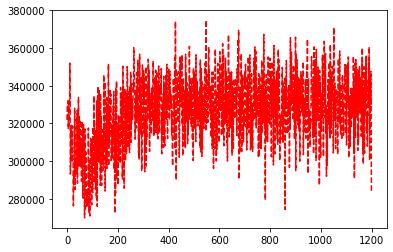

In [5]:
import matplotlib.pyplot as plt
plt.plot(cek1, cek2, 'r--')
plt.show()

In [6]:
# Q = np.loadtxt('Q.txt')
# Q

In [7]:
best_distance = 0
total_dis = []
for n in range(len(croute)):
    item_distance = 0
    item_route = croute[n]
    for i in range(len(item_route)):
        item_distance+=distance[item_route[i][0]][item_route[i][1]]
    total_dis.append(item_distance)    
        
for n in range(len(croute)):
    print("Rute "+str(n))
    print(str(croute[n])+" -> "+str(total_dis[n]))
    best_distance+=total_dis[n]
print("Total Distace : "+str(best_distance))
print(elapsed)

Rute 0
[[0, 10], [10, 18], [18, 11], [11, 4], [4, 9], [9, 5], [5, 0]] -> 16772.0
Rute 1
[[0, 23], [23, 19], [19, 8], [8, 17], [17, 2], [2, 14], [14, 0]] -> 17196.0
Rute 2
[[0, 36], [36, 15], [15, 35], [35, 34], [34, 38], [38, 48], [48, 0]] -> 42350.0
Rute 3
[[0, 1], [1, 24], [24, 41], [41, 42], [42, 7], [7, 0]] -> 35687.0
Rute 4
[[0, 20], [20, 47], [47, 28], [28, 31], [31, 16], [16, 22], [22, 0]] -> 45221.0
Rute 5
[[0, 50], [50, 30], [30, 40], [40, 37], [37, 43], [43, 0]] -> 38406.0
Rute 6
[[0, 44], [44, 13], [13, 29], [29, 27], [27, 33], [33, 32], [32, 12], [12, 0]] -> 51312.0
Rute 7
[[0, 3], [3, 6], [6, 49], [49, 21], [21, 45], [45, 46], [46, 25], [25, 0]] -> 26080.0
Rute 8
[[0, 39], [39, 26], [26, 0]] -> 9922.0
Total Distace : 282946.0
88.31348633766174


In [8]:
print(elapsed)

88.31348633766174
